In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import datetime
import calendar

print("Setup Complete")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Setup Complete
/kaggle/input/walmart-sales/Walmart_sales.csv


In [2]:
df = pd.read_csv('/kaggle/input/walmart-sales/Walmart_sales.csv')
# df['Date'] = df['Date'].to_period("D")

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [4]:
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


In [5]:
# df.groupby(df['date_column'].dt.year)
# Avg_Sales = Avg_Sales.groupby('Date').agg({'Weekly_Sales':'mean',
#                                           'Holiday_Flag':'max',
#                                           'Temperature':'mean',
#                                           'Fuel_Price':'mean',
#                                           'CPI':'mean',
#                                           'Unemployment':'mean',
#                                     })\
# .sort_values(by='Date', ascending=True)
df.groupby(df['Date'].dt.year).agg({'Weekly_Sales':'mean',
                                          'Holiday_Flag':'max',
                                          'Temperature':'mean',
                                          'Fuel_Price':'mean',
                                          'CPI':'mean',
                                          'Unemployment':'mean',
                                    })\
.sort_values(by='Date', ascending=True)

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010,1.059670e+06,1,60.266958,2.823767,168.101782,8.492714
2011,1.046239e+06,1,58.798530,3.561915,171.545716,8.082036
2012,1.033660e+06,1,63.362403,3.709776,175.498781,7.347964


In [6]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


Will split data with 75% of the dates in training and 25% in testing!

In [7]:
X = df.drop(labels=['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

In [8]:
X_train, X_test = X.loc[X['Date']<'2012-02-24', :], X.loc[X['Date']>='2012-02-24',:]
y_train, y_test = y.loc[X['Date']<'2012-02-24'], y.loc[X['Date']>='2012-02-24']

In [9]:
df_train = pd.concat([X_train, y_train], axis=1)

In [10]:
df_train.set_index(['Store', 'Date'], inplace=True)

# EDA!

In [11]:
df_train.head()

Holiday_Flag  Temperature  Fuel_Price         CPI  \
Store Date                                                            
1     2010-02-05             0        42.31       2.572  211.096358   
      2010-02-12             1        38.51       2.548  211.242170   
      2010-02-19             0        39.93       2.514  211.289143   
      2010-02-26             0        46.63       2.561  211.319643   
      2010-03-05             0        46.50       2.625  211.350143   

                  Unemployment  Weekly_Sales  
Store Date                                    
1     2010-02-05         8.106    1643690.90  
      2010-02-12         8.106    1641957.44  
      2010-02-19         8.106    1611968.17  
      2010-02-26         8.106    1409727.59  
      2010-03-05         8.106    1554806.68

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4815 entries, (1, Timestamp('2010-02-05 00:00:00')) to (45, Timestamp('2012-02-17 00:00:00'))
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Holiday_Flag  4815 non-null   int64  
 1   Temperature   4815 non-null   float64
 2   Fuel_Price    4815 non-null   float64
 3   CPI           4815 non-null   float64
 4   Unemployment  4815 non-null   float64
 5   Weekly_Sales  4815 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 241.5 KB


In [13]:
df_train.isnull().sum()

Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Weekly_Sales    0
dtype: int64

In [14]:
df_train.duplicated().sum()

0

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Date', ylabel='Weekly_Sales'>

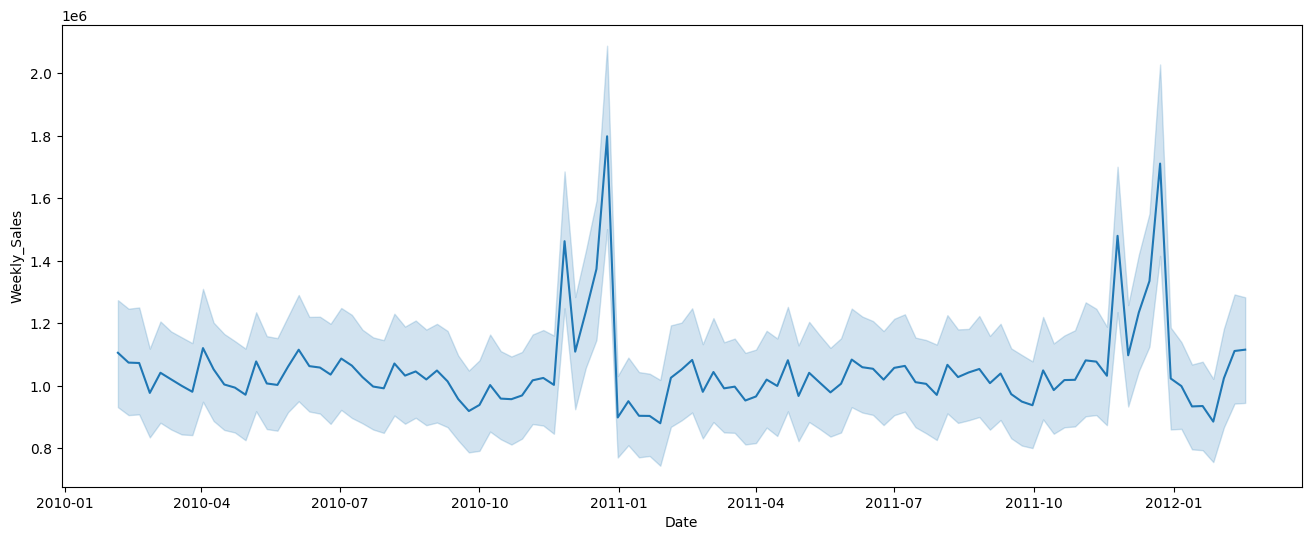

In [15]:
# Set the width and height of the figure
plt.figure(figsize=(16,6))
sns.lineplot(data=df_train, x="Date", y="Weekly_Sales")

Looks like end of the year has higher sales on average! 👀 Thanksgiving and Christmas season maybe?

In [16]:
Avg_Store_Sales = df_train.groupby('Store').agg({'Weekly_Sales':'mean'})\
.rename(columns={'Weekly_Sales':'Avg_Weekly_Sales'})\
.sort_values(by='Avg_Weekly_Sales', ascending=False)

Avg_Store_Sales.head()

,Avg_Weekly_Sales
Store,
20,2.112856e+06
14,2.097884e+06
4,2.071698e+06
13,1.992786e+06
2,1.934934e+06


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

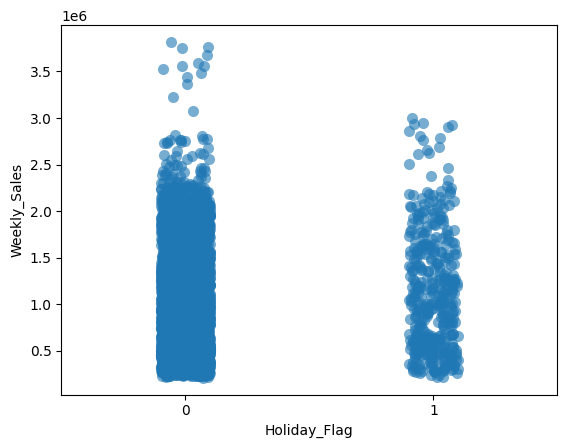

In [17]:
sns.stripplot(x='Holiday_Flag',
             y='Weekly_Sales',
             data=df_train,
             jitter=True,
             alpha=0.6,
             size=8,
             )

Strip plot showing weekly sales by holiday flag, but there are a lot more non-holiday days so it is hard to compare. Will look at violin plot to see distribution.

<Axes: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

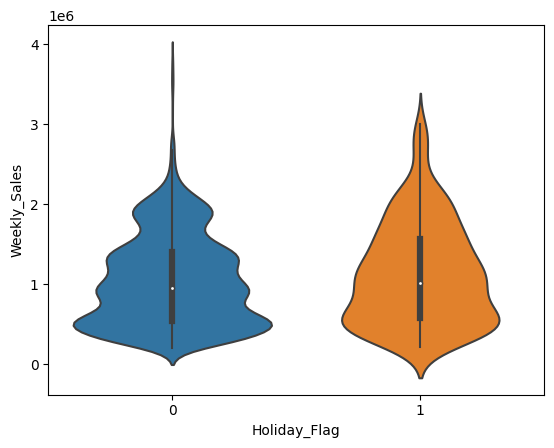

In [18]:
sns.violinplot(
    x='Holiday_Flag',
    y='Weekly_Sales',
    data=df_train,
)

Violin plot shows that average weekly sales of weeks including holidays is slightly higher than the other weeks, with more of the distribution falling into the higher ranges.

<Axes: >

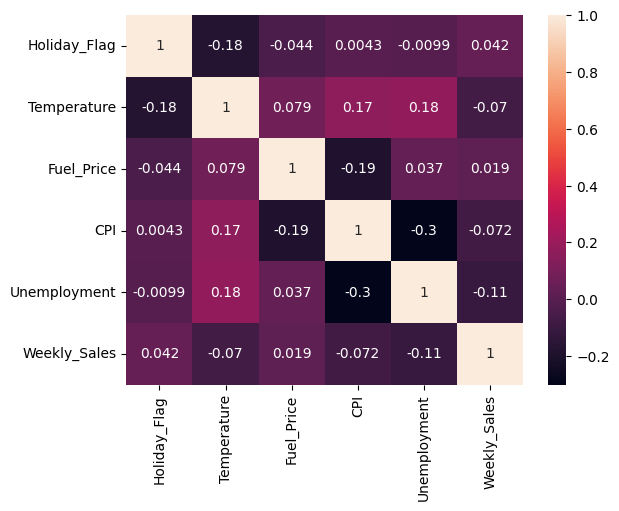

In [19]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True)

There doesn't seem to be strong correlation, positive or negative, between most of the variables. Unemployment is at least a bit negatively correlated with weekly sales.

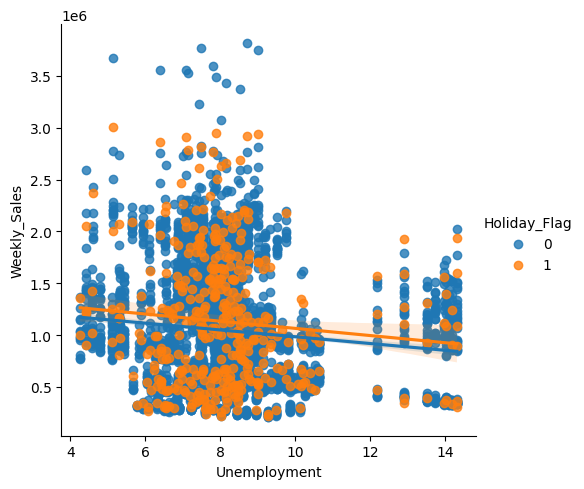

In [20]:
sns.lmplot(x="Unemployment", y="Weekly_Sales", hue="Holiday_Flag", data=df_train)

Scatterplot with regression lines! We see unemployement and weekly sales being negatively correlated, for both holiday and non-holiday weeks.

# Times Series Plots

## Linear Regression on Lagged Data

Adding in time dummy to count off time steps from beginning to end after using average weekly sales across stores.

In [21]:
df_train.head()

Holiday_Flag  Temperature  Fuel_Price         CPI  \
Store Date                                                            
1     2010-02-05             0        42.31       2.572  211.096358   
      2010-02-12             1        38.51       2.548  211.242170   
      2010-02-19             0        39.93       2.514  211.289143   
      2010-02-26             0        46.63       2.561  211.319643   
      2010-03-05             0        46.50       2.625  211.350143   

                  Unemployment  Weekly_Sales  
Store Date                                    
1     2010-02-05         8.106    1643690.90  
      2010-02-12         8.106    1641957.44  
      2010-02-19         8.106    1611968.17  
      2010-02-26         8.106    1409727.59  
      2010-03-05         8.106    1554806.68

In [22]:
Avg_Sales = df_train.reset_index()

In [23]:
Avg_Sales = Avg_Sales.groupby('Date').agg({'Weekly_Sales':'mean',
                                          'Holiday_Flag':'max',
                                          'Temperature':'mean',
                                          'Fuel_Price':'mean',
                                          'CPI':'mean',
                                          'Unemployment':'mean',
                                    })\
.sort_values(by='Date', ascending=True)

In [24]:
Avg_Sales.index = Avg_Sales.index.to_period("D")

In [25]:
Avg_Sales['Time'] = np.arange(len(Avg_Sales.index))

In [26]:
Avg_Sales.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Time
Date,,,,,,,
2010-02-05,1.105572e+06,0,34.037333,2.717844,167.730885,8.619311,0
2010-02-12,1.074148e+06,1,34.151333,2.694022,167.825608,8.619311,1
2010-02-19,1.072822e+06,0,37.719778,2.672067,167.871686,8.619311,2
2010-02-26,9.770794e+05,0,39.243556,2.683933,167.909657,8.619311,3
2010-03-05,1.041588e+06,0,42.917333,2.731200,167.947628,8.619311,4


/tmp/ipykernel_18/3778906820.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


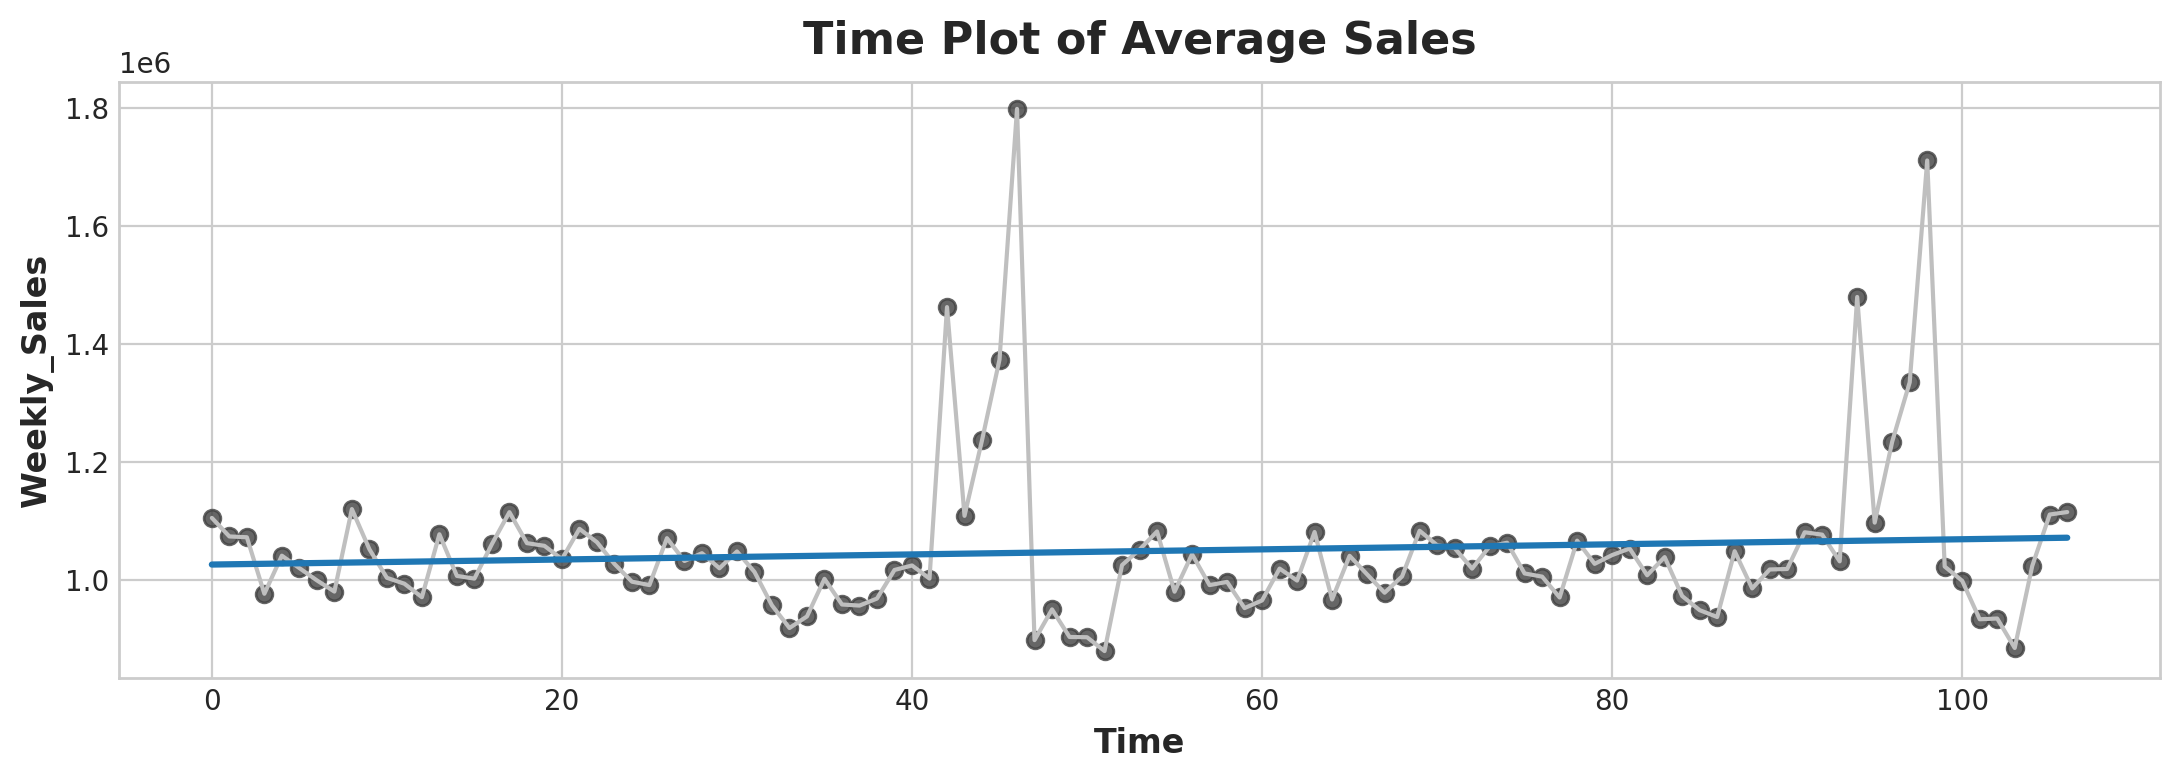

In [27]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Weekly_Sales', data=Avg_Sales, color='0.75')
ax = sns.regplot(x='Time', y='Weekly_Sales', data=Avg_Sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Average Sales');

Creating lag feature:

In [28]:
Avg_Sales['Lag_1'] = Avg_Sales['Weekly_Sales'].shift(1)
Avg_Sales_Lag = Avg_Sales.reindex(columns=['Weekly_Sales', 'Lag_1'])

Avg_Sales_Lag.head()

,Weekly_Sales,Lag_1
Date,,
2010-02-05,1.105572e+06,NaN
2010-02-12,1.074148e+06,1.105572e+06
2010-02-19,1.072822e+06,1.074148e+06
2010-02-26,9.770794e+05,1.072822e+06
2010-03-05,1.041588e+06,9.770794e+05


Text(0.5, 1.0, 'Lag Plot of Weekly Sales')

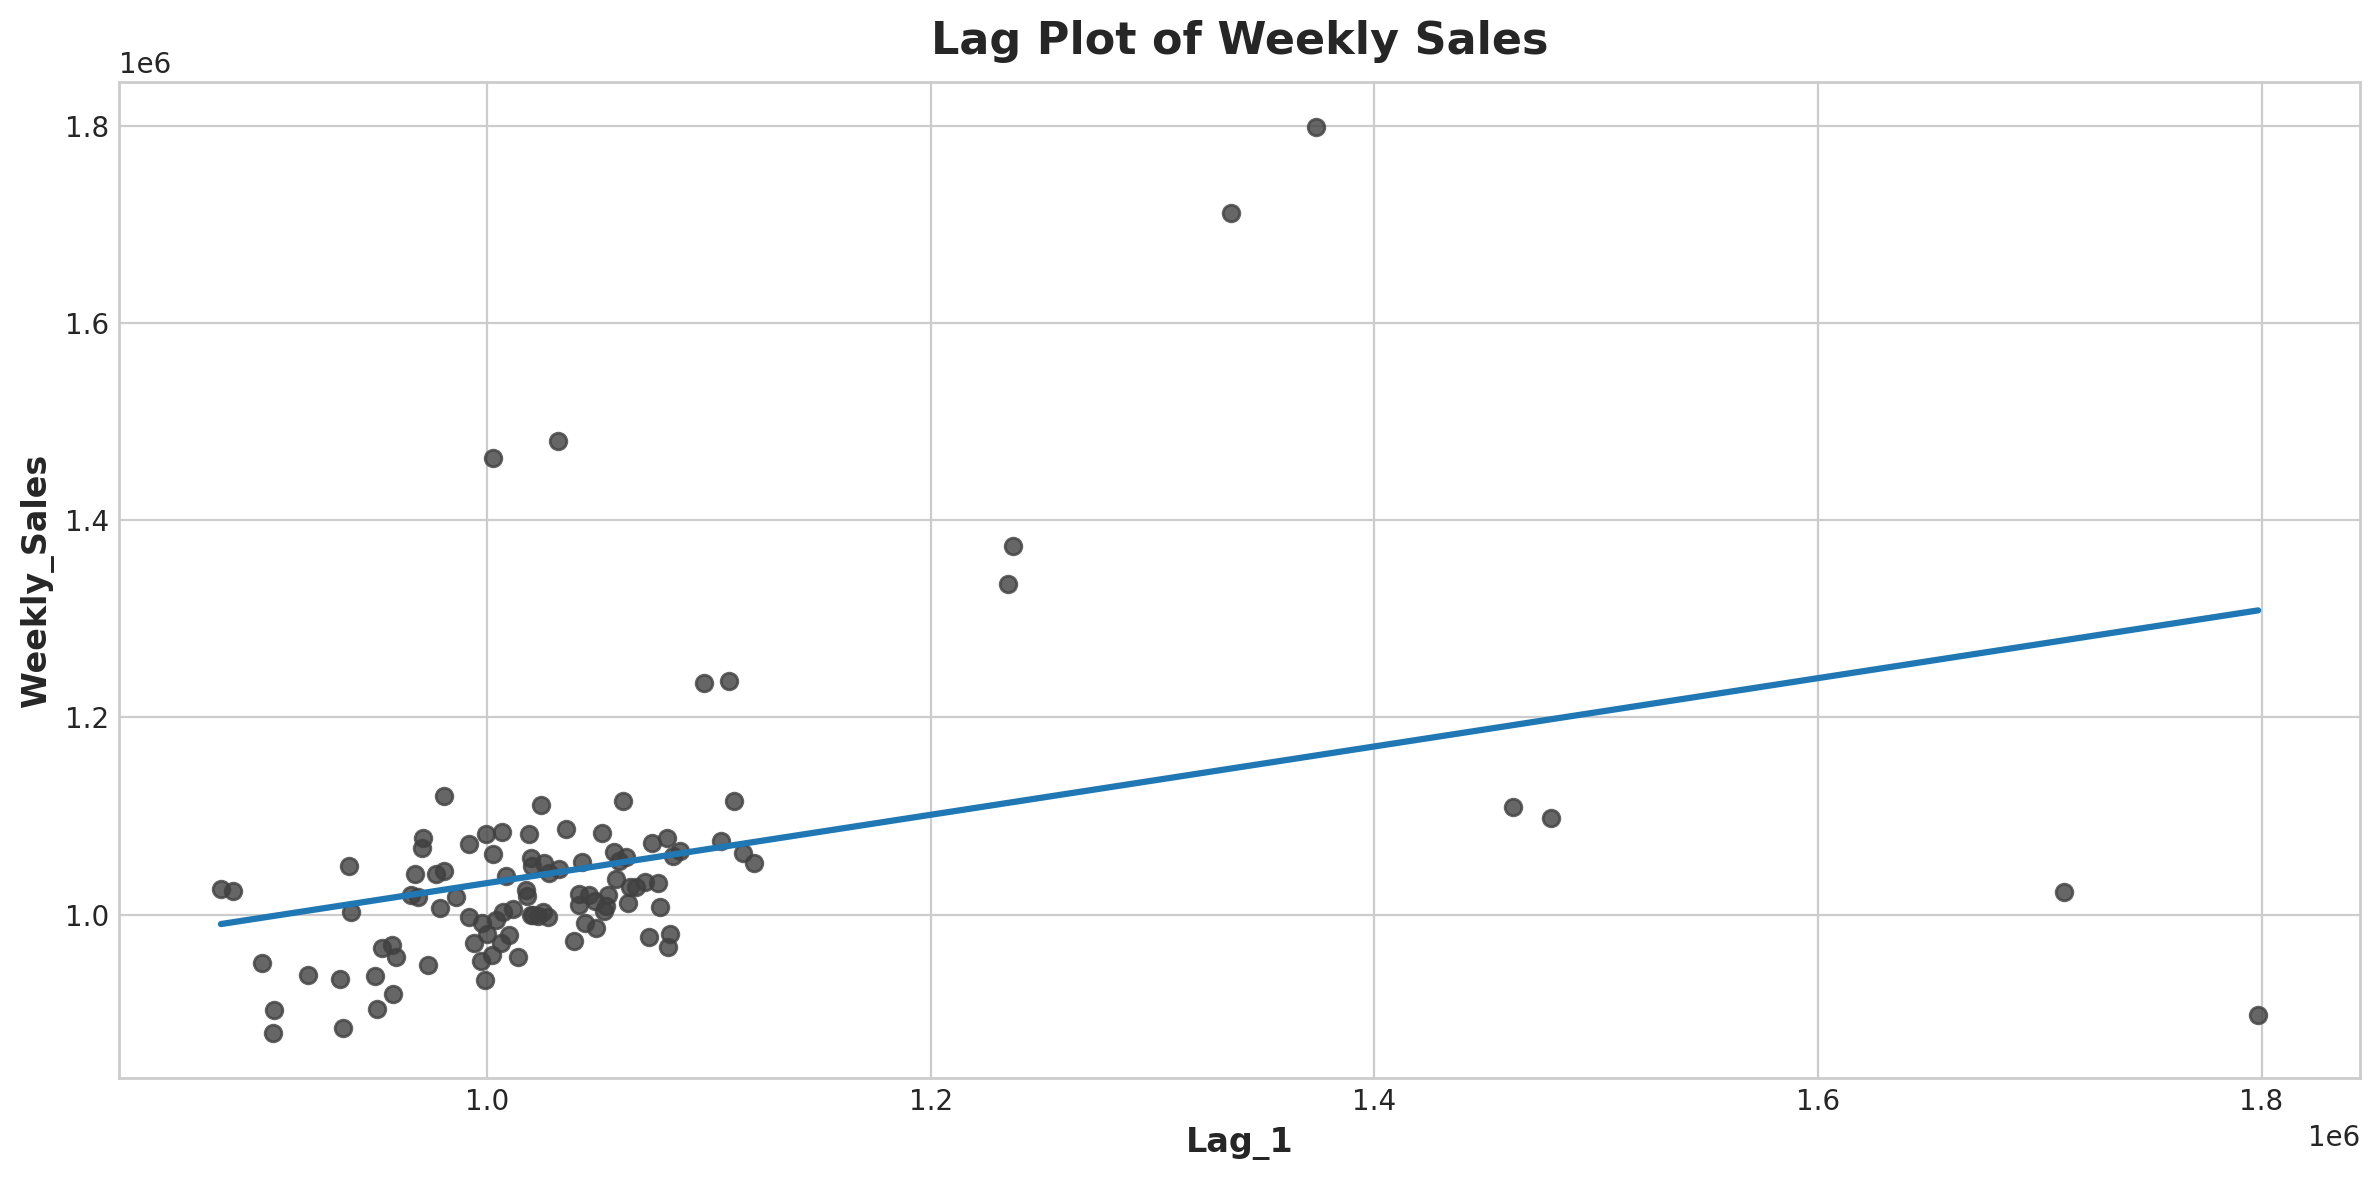

In [29]:
# fig, ax = plt.subplots()
plt.figure(figsize=(12,6))
# ax = 
sns.regplot(x='Lag_1', y='Weekly_Sales', data=Avg_Sales_Lag, ci=None, scatter_kws=dict(color='0.25'))
# ax.set_aspect('equal')
# ax.set_title('Lag Plot of Weekly Sales');
plt.title('Lag Plot of Weekly Sales')

Perhaps the very high lagged sales is from a holiday week? We'll try looking at the plot excluding holiday weeks.

In [30]:
X = Avg_Sales.loc[Avg_Sales['Holiday_Flag']==0,['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = Avg_Sales.loc[:, 'Weekly_Sales']
y, X = y.align(X, join='inner')

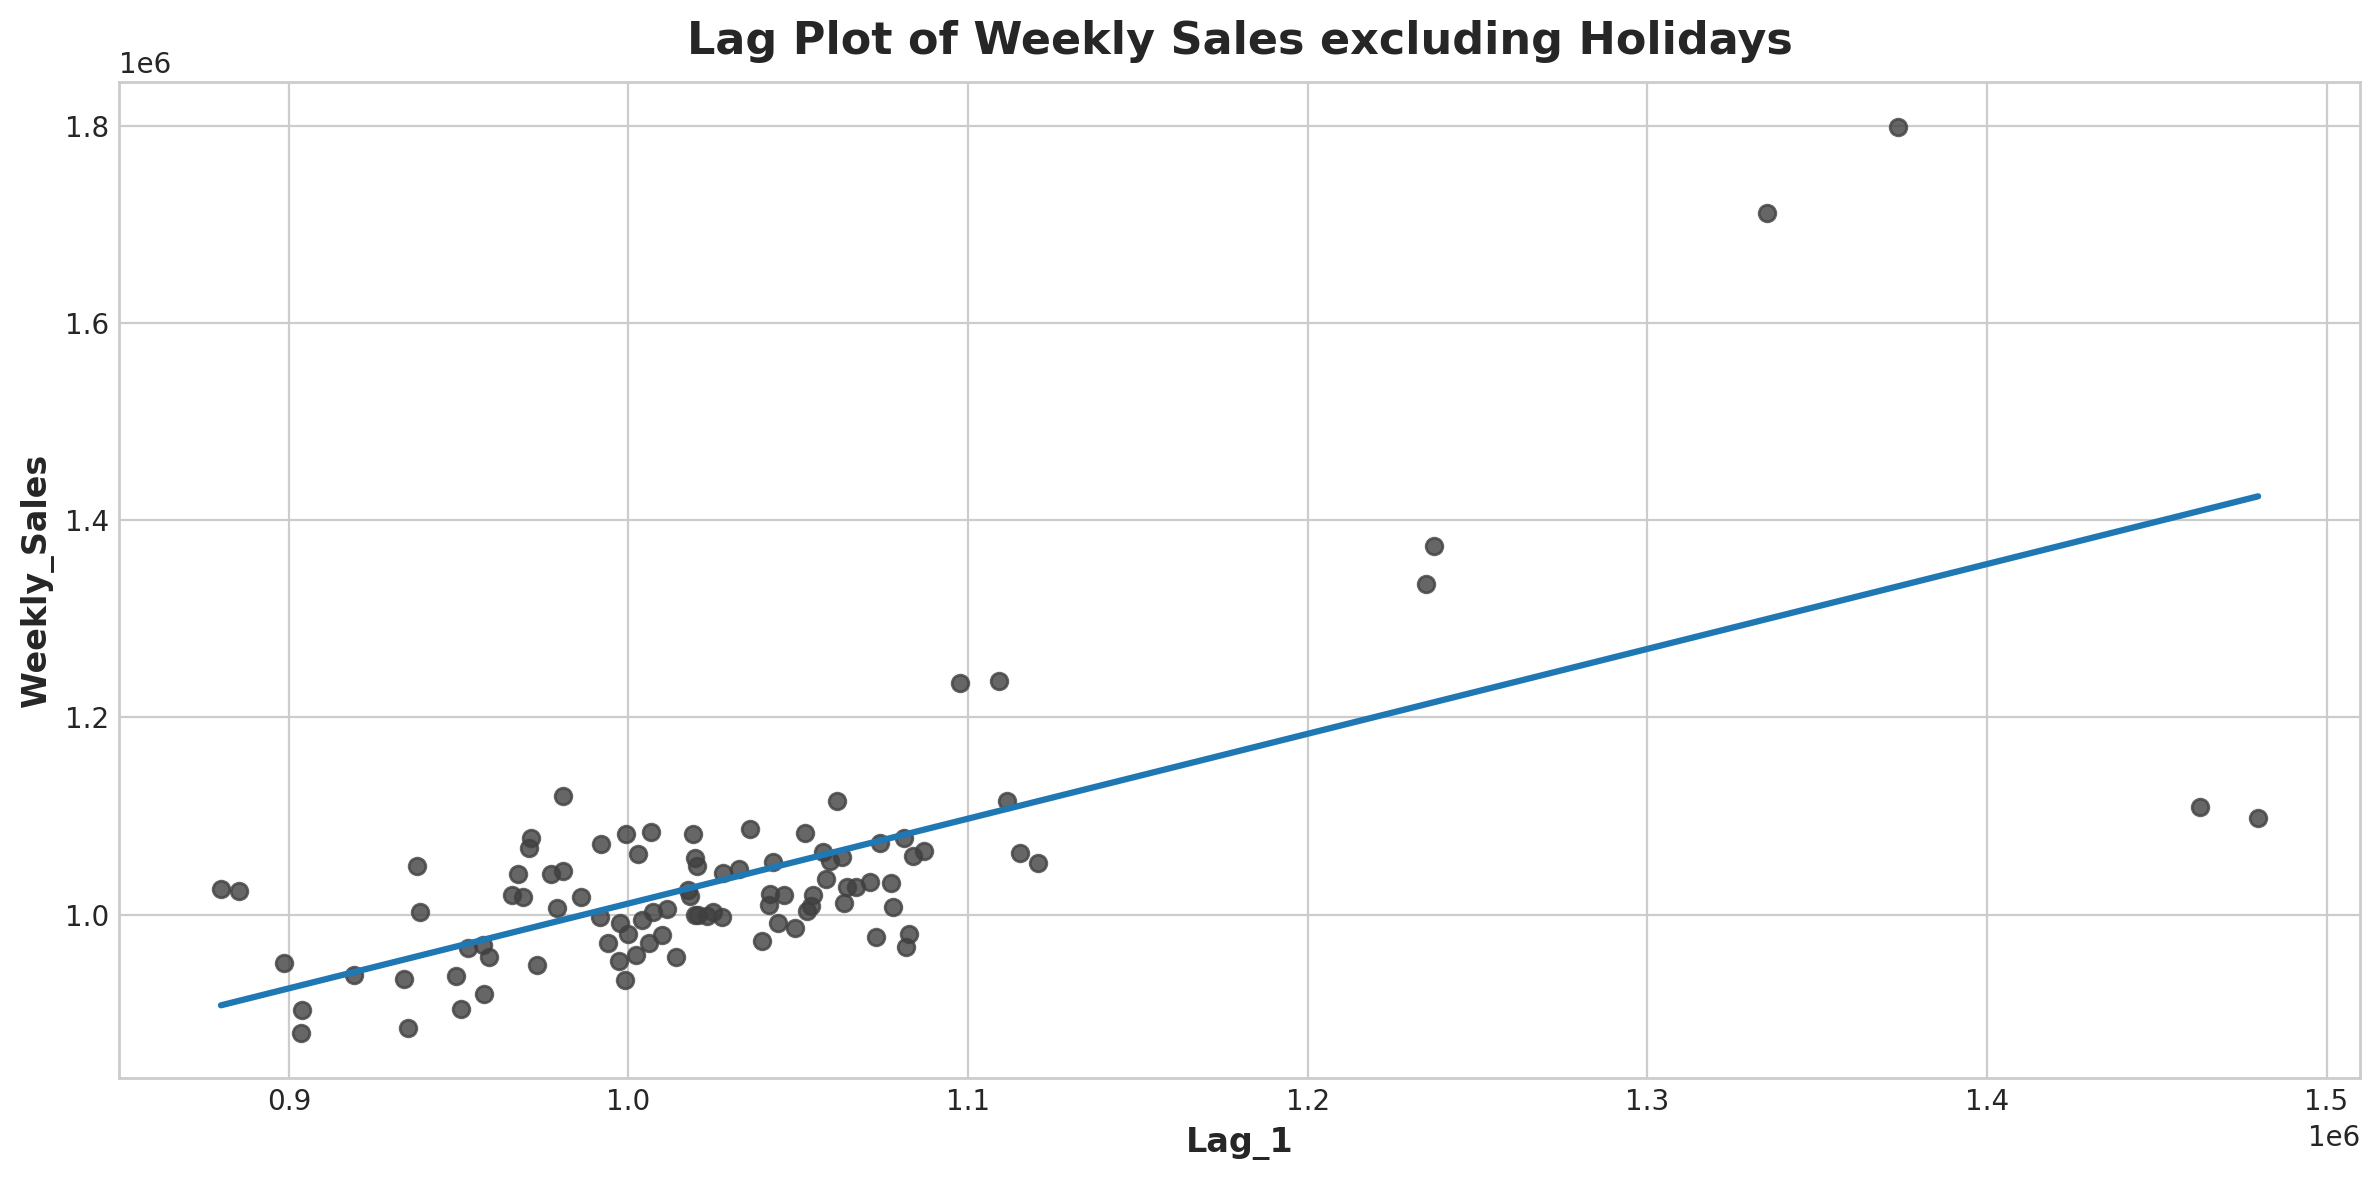

In [31]:
plt.figure(figsize=(12,6))
sns.regplot(x=X, y=y, ci=None, scatter_kws=dict(color='0.25'))
plt.title('Lag Plot of Weekly Sales excluding Holidays');

Let's try fitting a linear regression on this.

In [32]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index, name='Prediction')

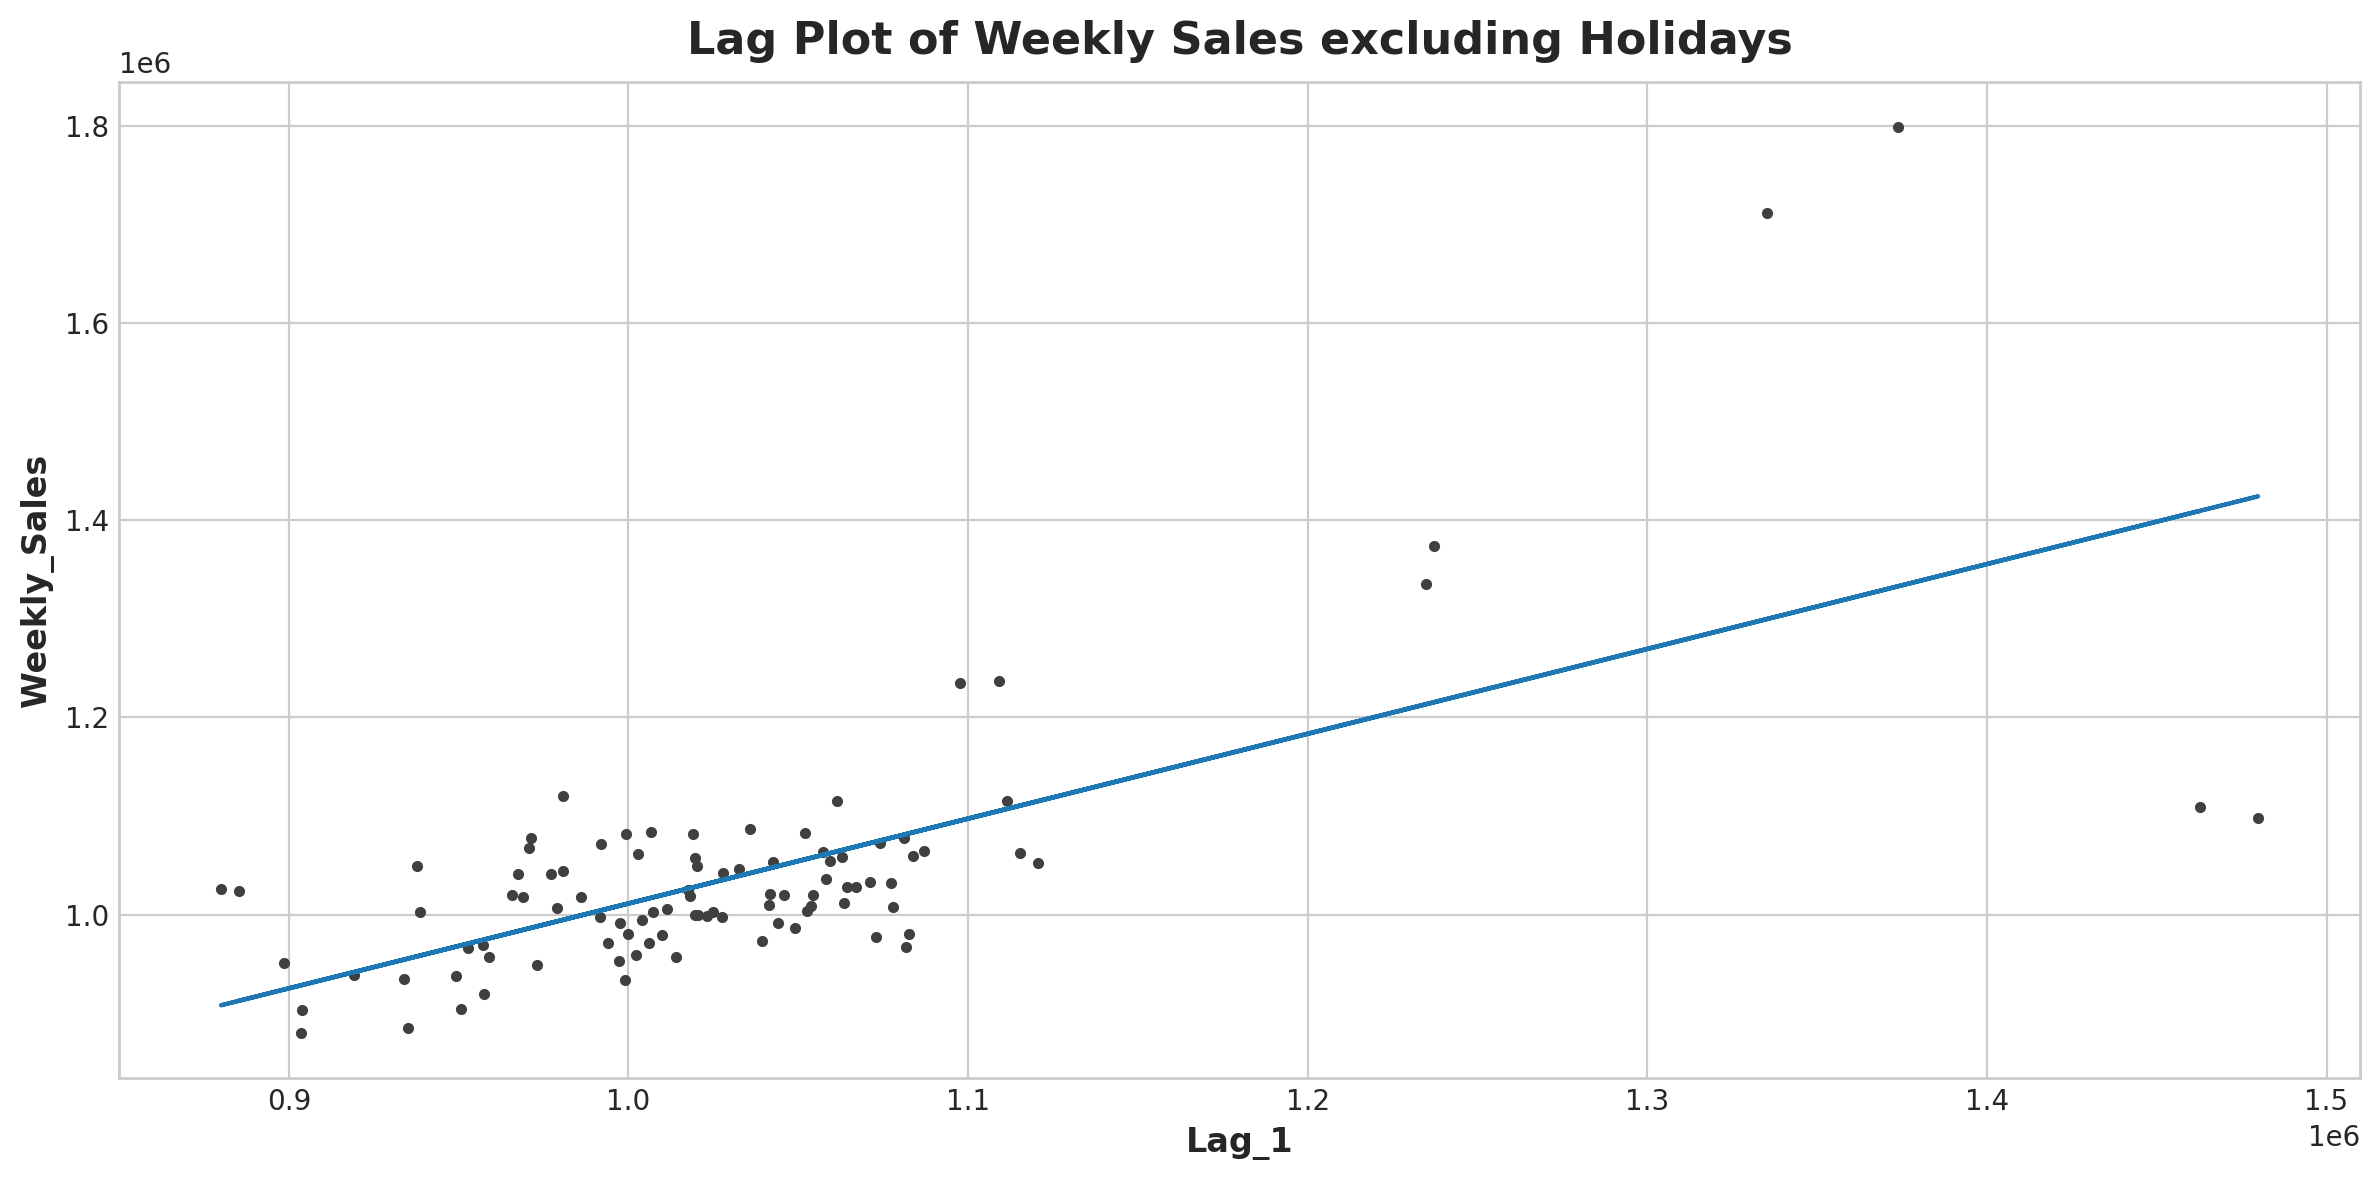

In [33]:
plt.figure(figsize=(12,6))
plt.plot(X['Lag_1'], y, '.', color='0.25')
plt.plot(X['Lag_1'], y_pred)
plt.xlabel('Lag_1')
plt.ylabel('Weekly_Sales')
plt.title('Lag Plot of Weekly Sales excluding Holidays');

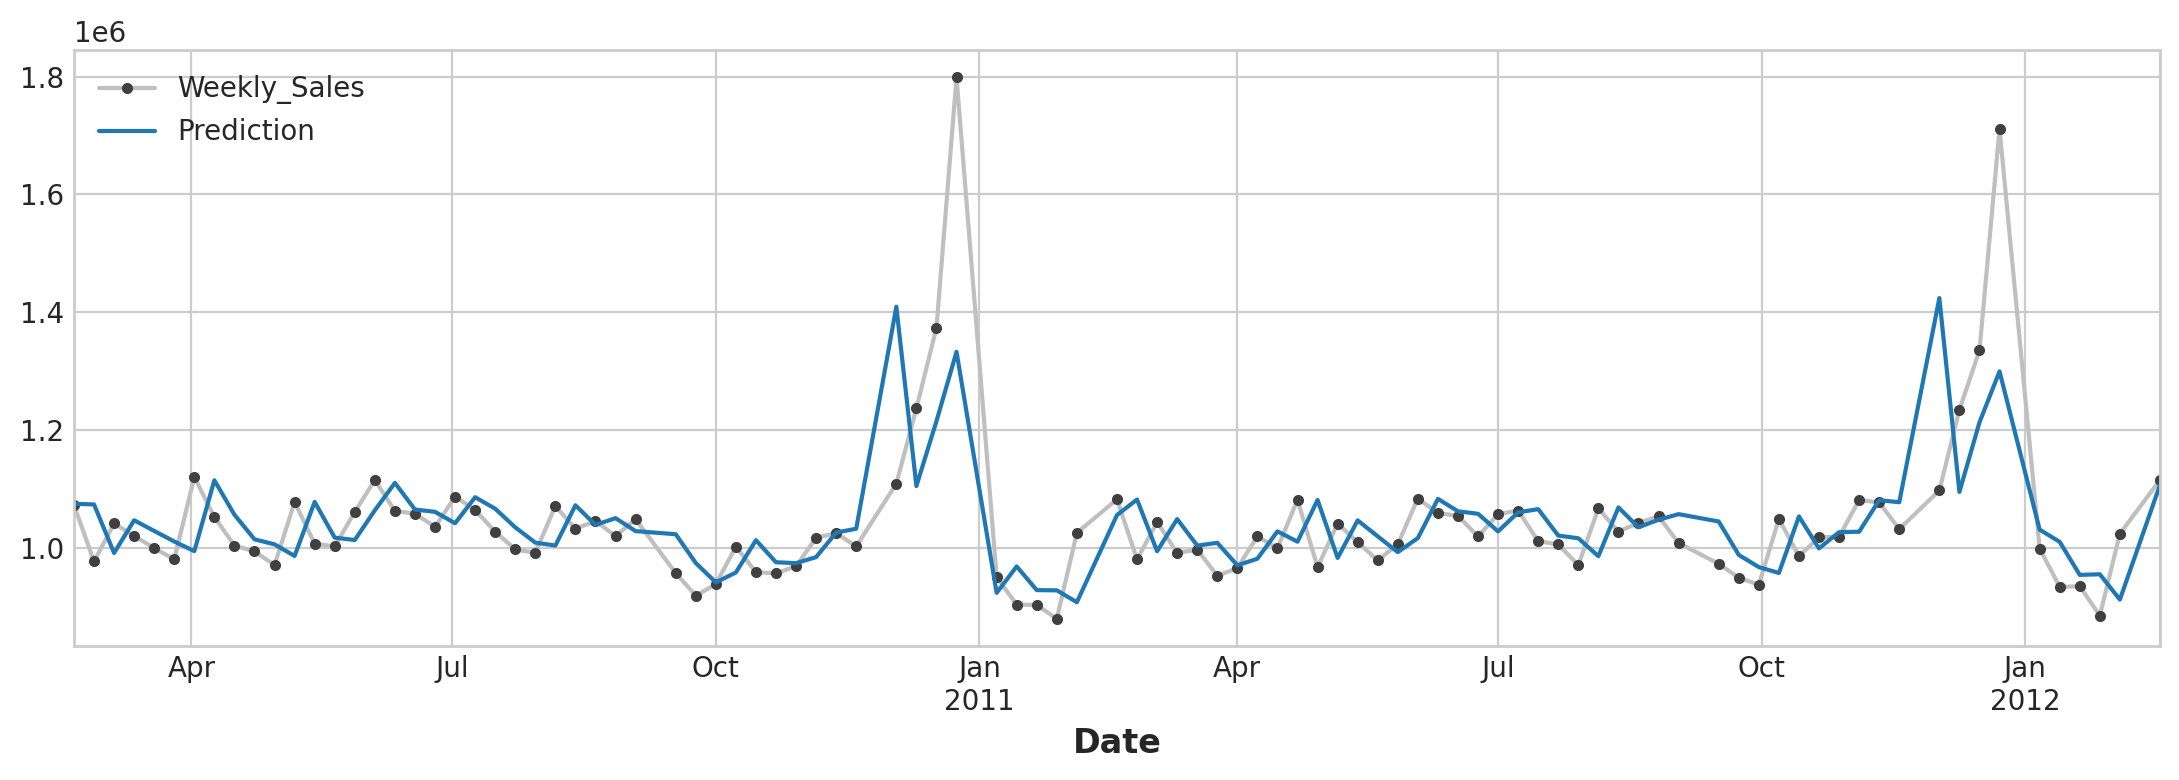

In [34]:
ax = y.plot(**plot_params)
ax = y_pred.plot(legend=True)

## Trend

Moving averages

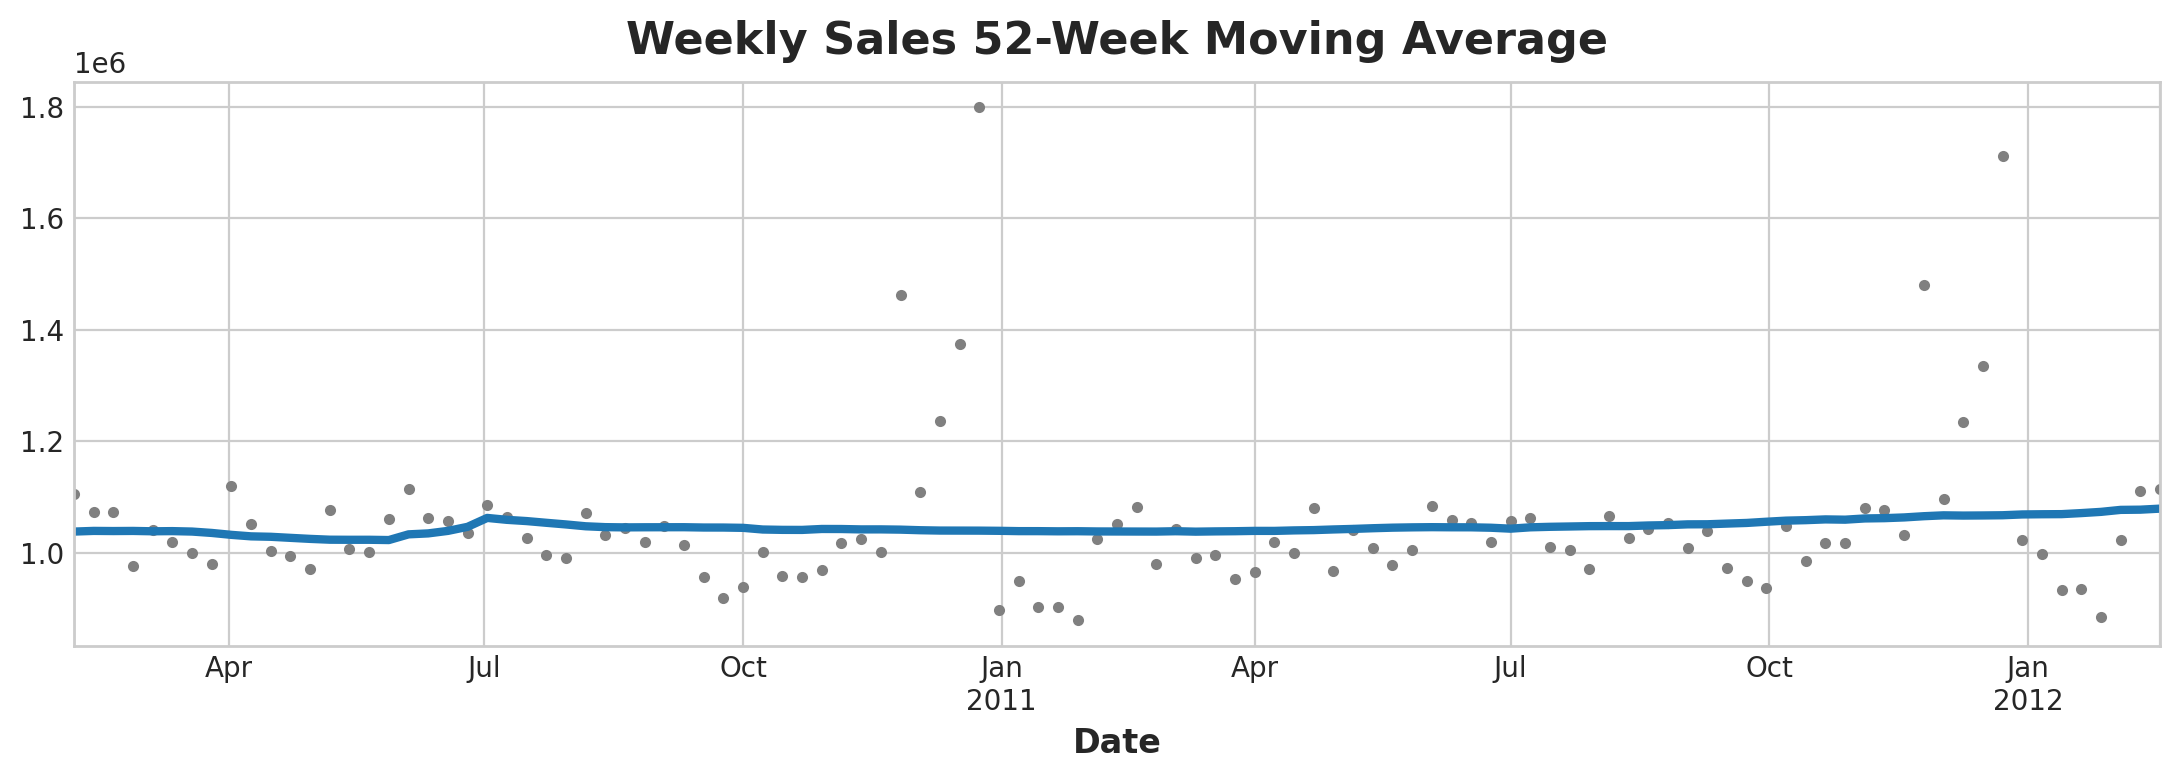

In [35]:
moving_average = Avg_Sales['Weekly_Sales'].rolling(
window=52,
center=True,
min_periods=26,
).mean()

ax = Avg_Sales['Weekly_Sales'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, 
    title="Weekly Sales 52-Week Moving Average", legend=False,
);

Barely any trend here over the two years

In [36]:
dp = DeterministicProcess(
    index=Avg_Sales.index,
    constant=True,           # y-intercept
    order=1,                 # trend
    drop=True,               # drop terms if necessary to avoid collinearity
)
# dp = DeterministicProcess(
#     index=Avg_Sales[['Week', 'Year']] ,
#     constant=True,  # Include intercept
#     seasonal=True,  # Include weekly seasonality
#     seasonal_periods=52  # Assuming 52 weeks in a year
# )
X = dp.in_sample()

X.head()

,const,trend
Date,,
2010-02-05,1.0,1.0
2010-02-12,1.0,2.0
2010-02-19,1.0,3.0
2010-02-26,1.0,4.0
2010-03-05,1.0,5.0


In [37]:
y = Avg_Sales['Weekly_Sales']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

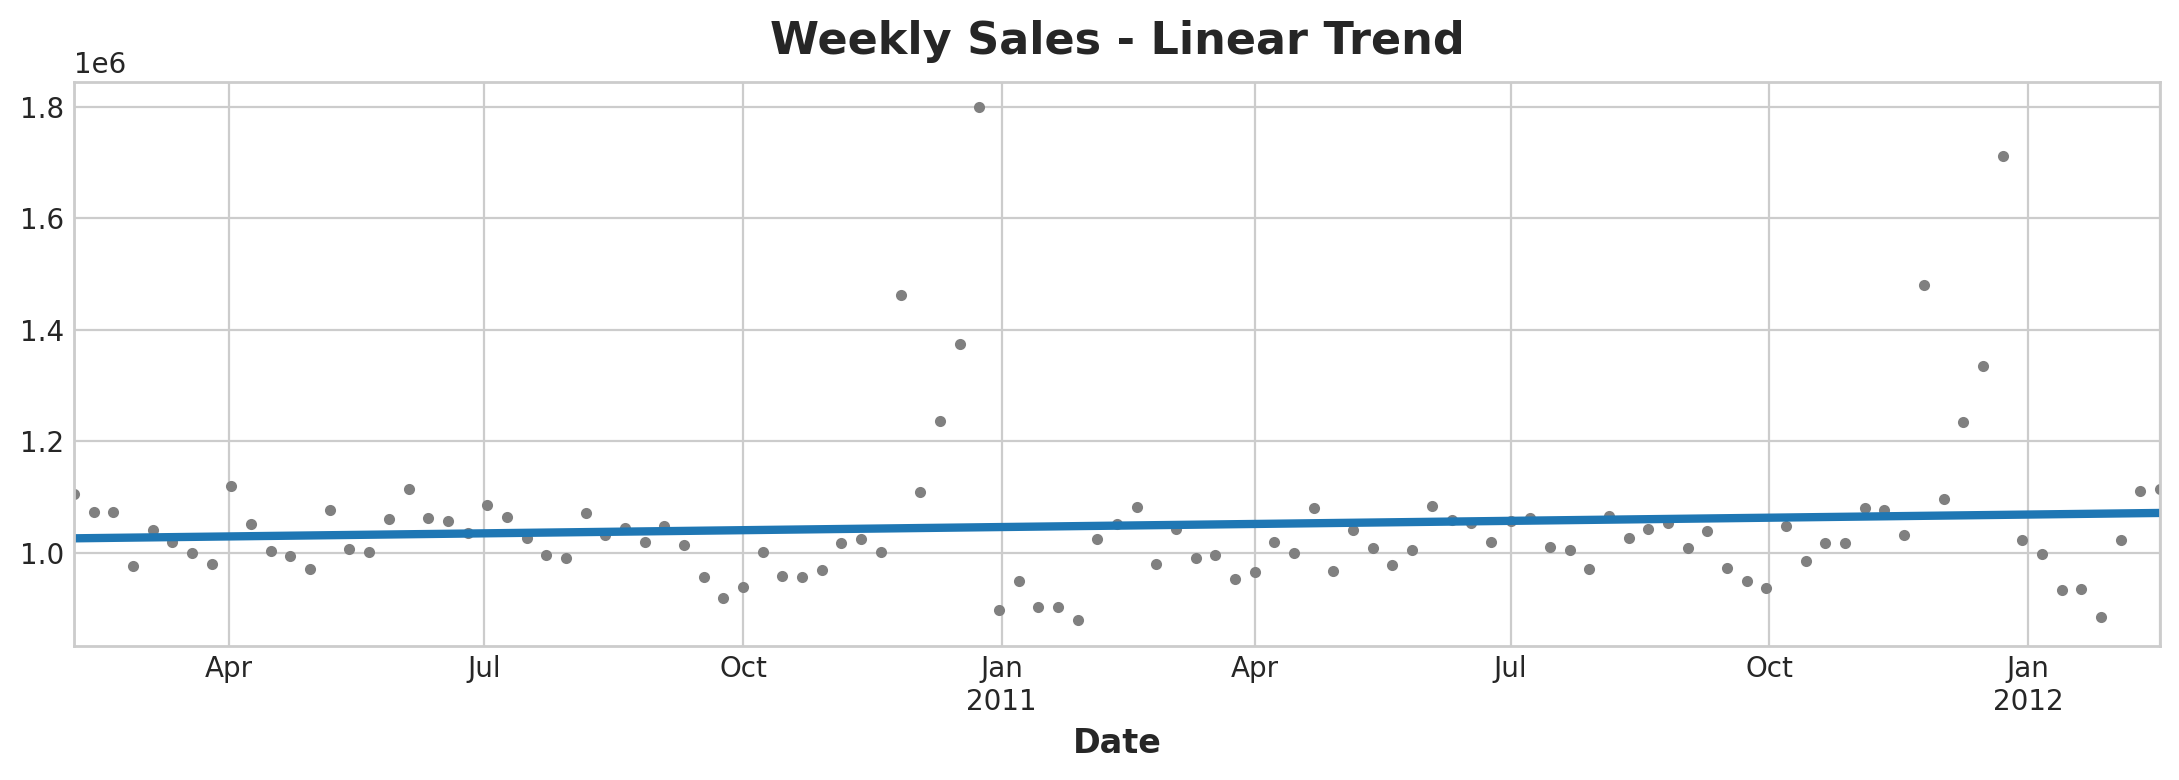

In [38]:
ax = Avg_Sales['Weekly_Sales'].plot(style=".", color="0.5", title="Weekly Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [39]:
next_5_weeks = pd.date_range(start=pd.Timestamp('2012-02-17'), periods=5, freq='W-FRI')

# Create a Series with dummy data
data = [0] * len(next_5_weeks)
next_5_weeks_series = pd.Series(data, index=next_5_weeks)
next_5_weeks_series.index = next_5_weeks_series.index.to_period("D")
forecast_dates = next_5_weeks_series.index
X_fore = dp.out_of_sample(steps=5, forecast_index=forecast_dates)

In [40]:
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

y_fore.head()

2012-02-17    1.072428e+06
2012-02-24    1.072857e+06
2012-03-02    1.073286e+06
2012-03-09    1.073714e+06
2012-03-16    1.074143e+06
Freq: D, dtype: float64

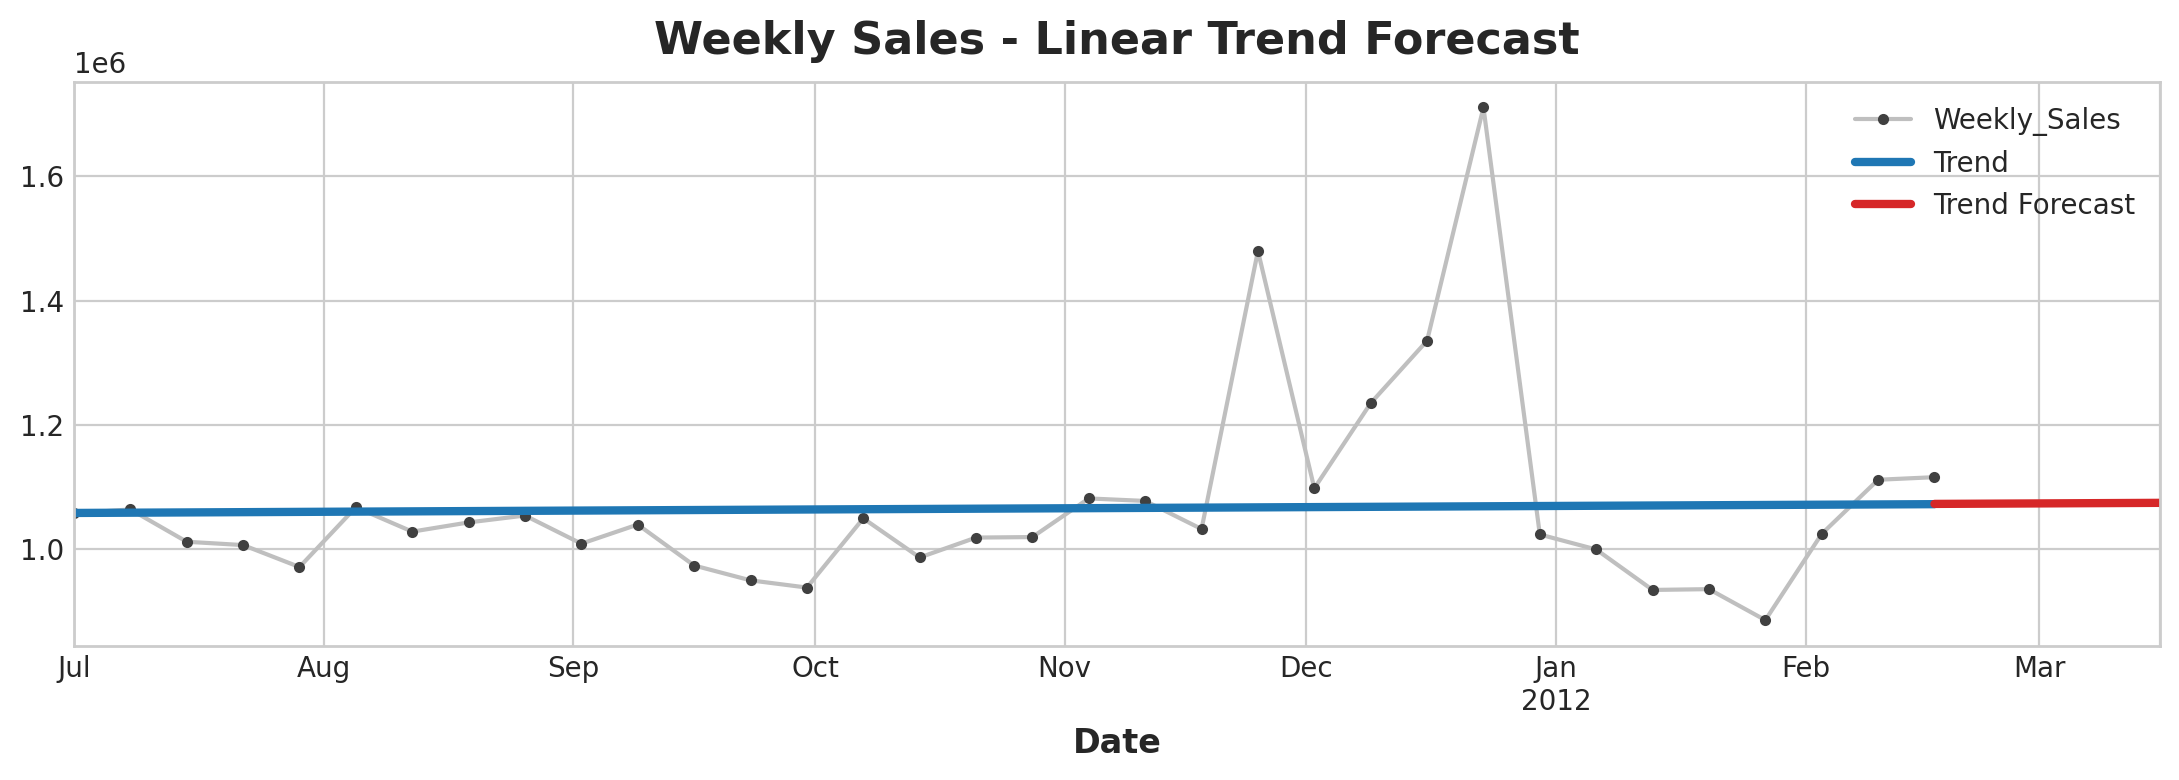

In [41]:
ax = Avg_Sales.loc["2011-07-01":,['Weekly_Sales']].plot(title="Weekly Sales - Linear Trend Forecast", **plot_params)
ax = y_pred["2011-07-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

essentially no trend at all..!

## Seasonality

In [42]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

In [43]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [44]:
Avg_Sales['dayofyear'] = Avg_Sales.index.dayofyear
Avg_Sales['week'] = Avg_Sales.index.week
Avg_Sales['year'] = Avg_Sales.index.year

/tmp/ipykernel_18/2914331047.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/c

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='Weekly_Sales'>

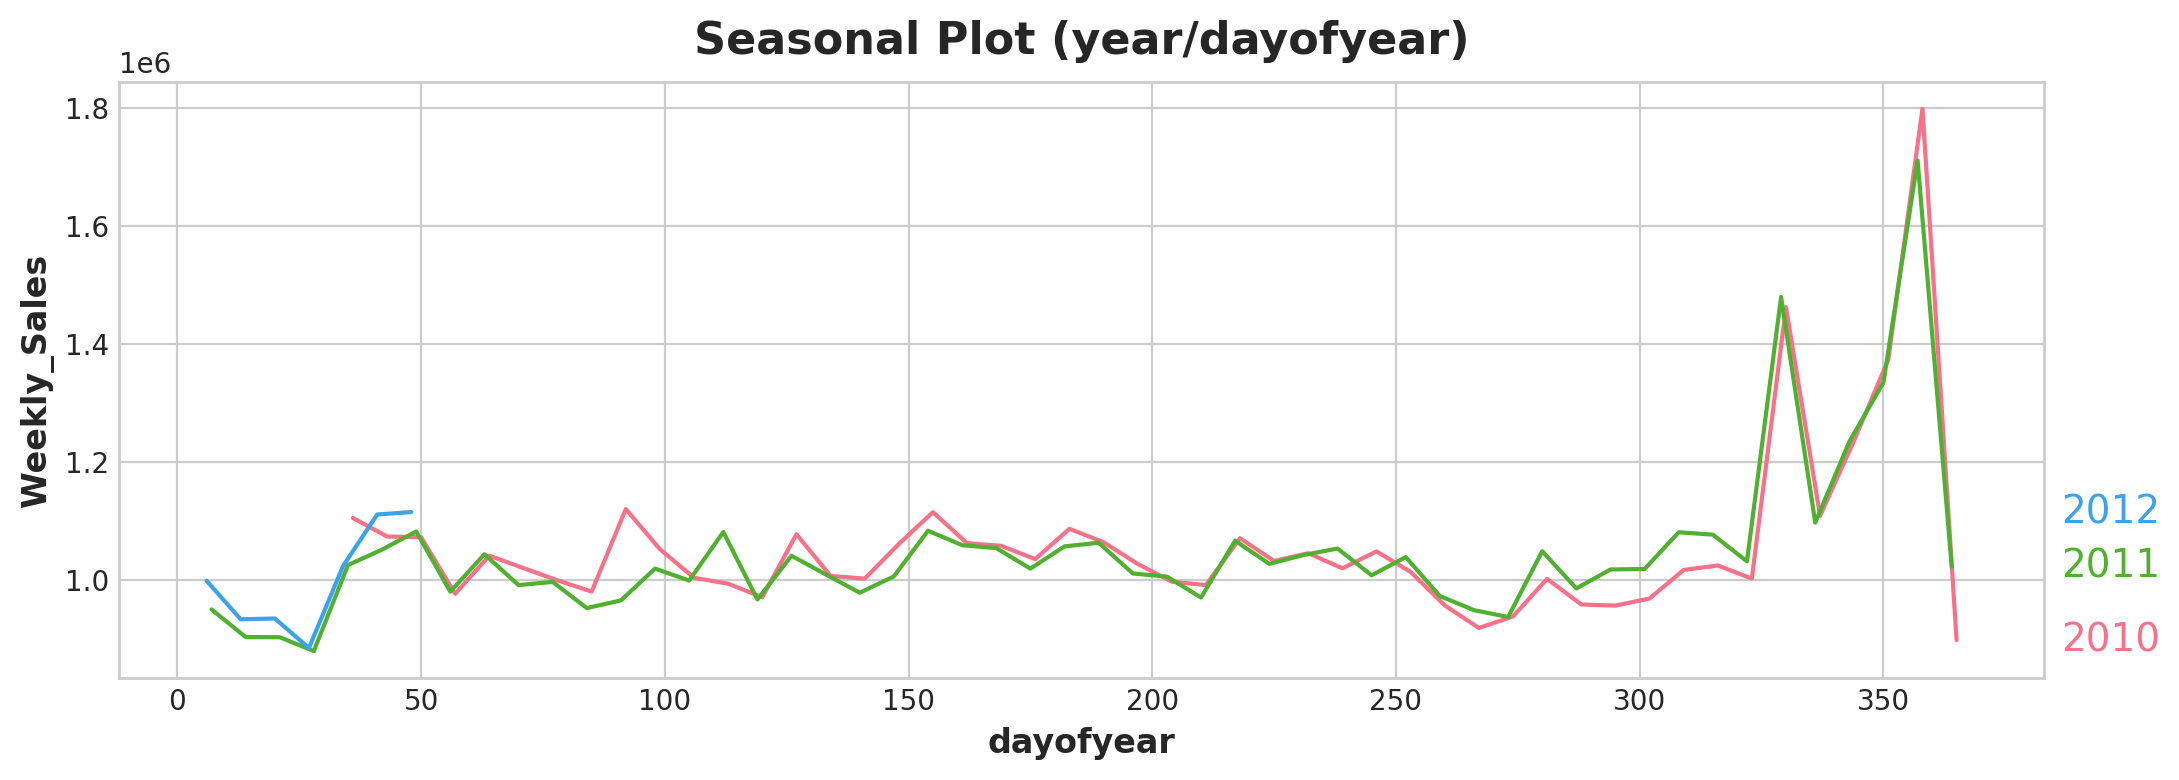

In [45]:
seasonal_plot(Avg_Sales, y="Weekly_Sales", period="year", freq="dayofyear")

There seems to be a bit of seasonality, where there's two peaks at end of the year

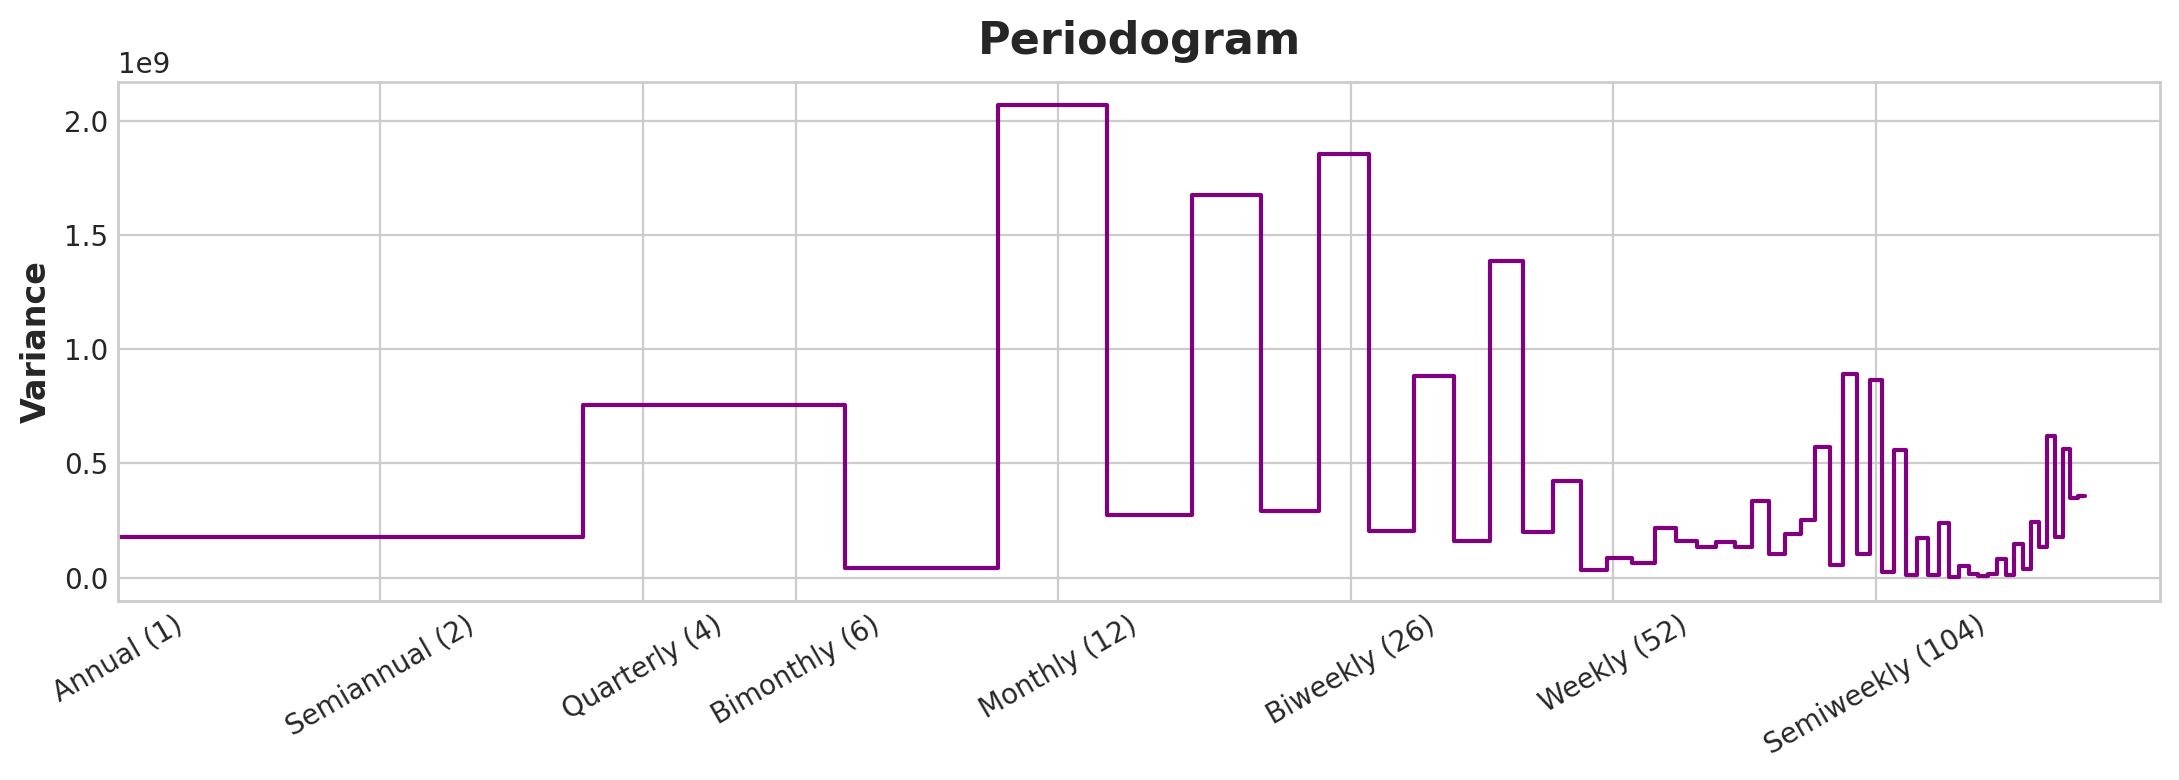

In [46]:
plot_periodogram(Avg_Sales.Weekly_Sales);

In [47]:
fourier = CalendarFourier(freq="A", order=12)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=Avg_Sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
#     seasonal=False,          # annual seasonality (fourier)
    additional_terms=[fourier],  
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [48]:
next_12_weeks = pd.date_range(start=pd.Timestamp('2012-02-17'), periods=12, freq='W-FRI')

# Create a Series with dummy data
data = [0] * len(next_12_weeks)
next_12_weeks_series = pd.Series(data, index=next_12_weeks)
next_12_weeks_series.index = next_12_weeks_series.index.to_period("D")
forecast_dates = next_12_weeks_series.index
X_fore = dp.out_of_sample(steps=12, forecast_index=forecast_dates)

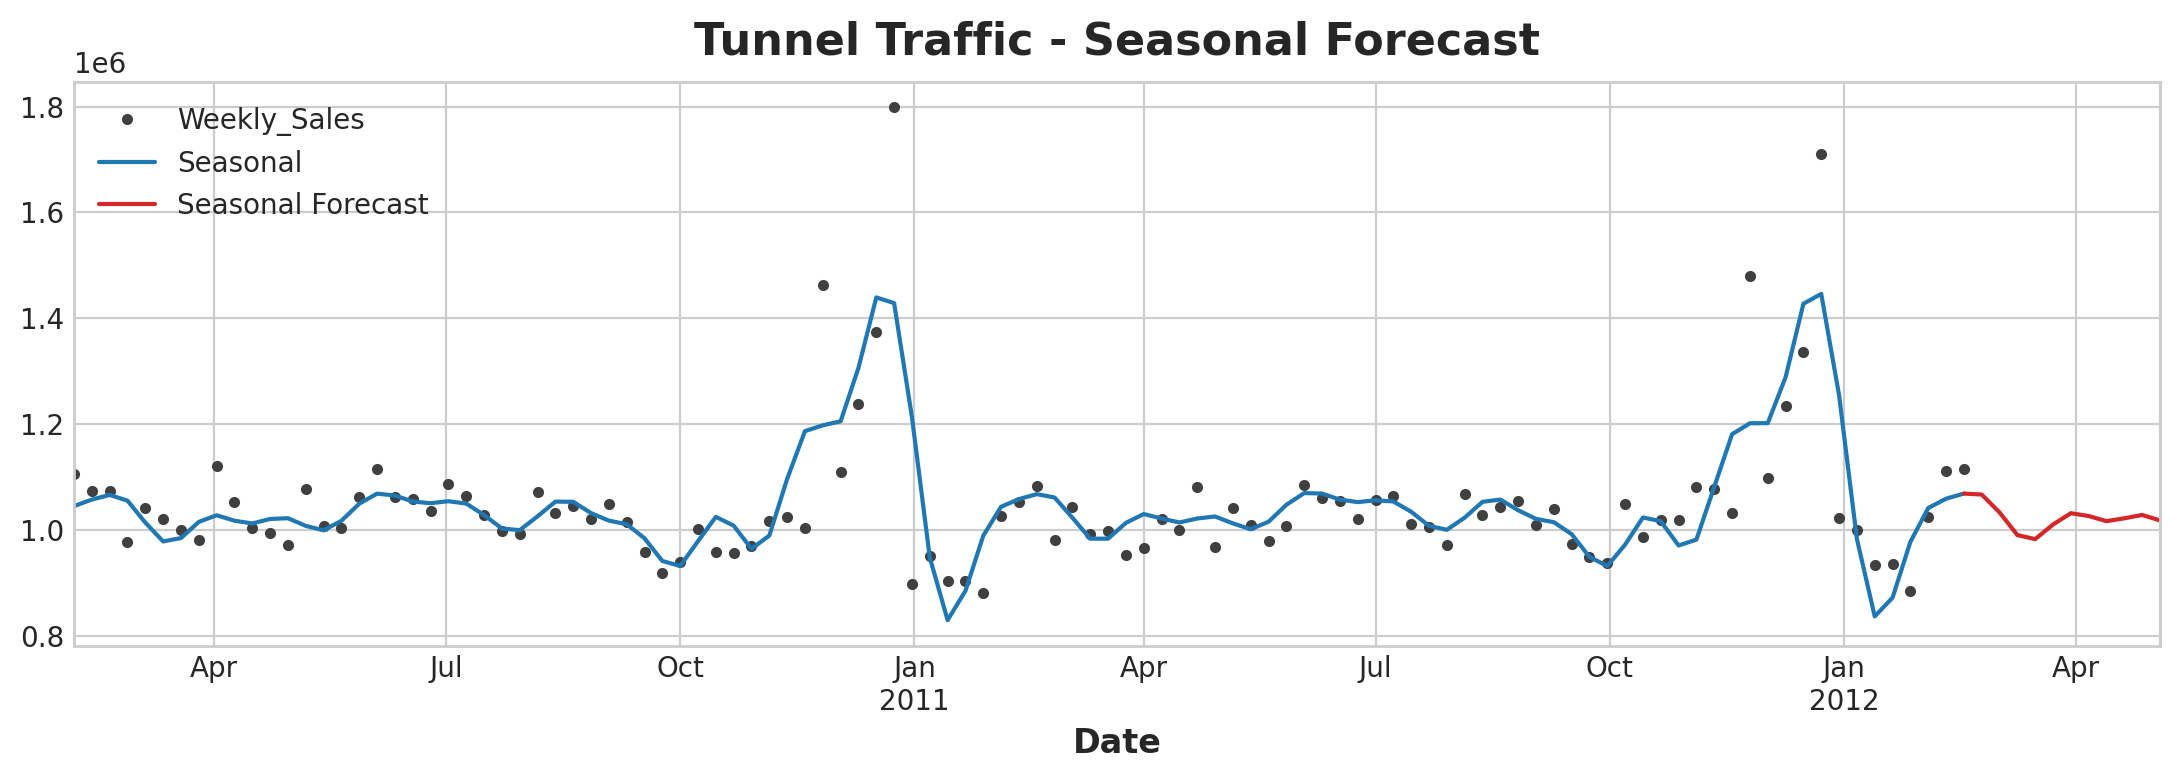

In [49]:
y = Avg_Sales["Weekly_Sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=y.index)
# X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

## Lag Features

In [50]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

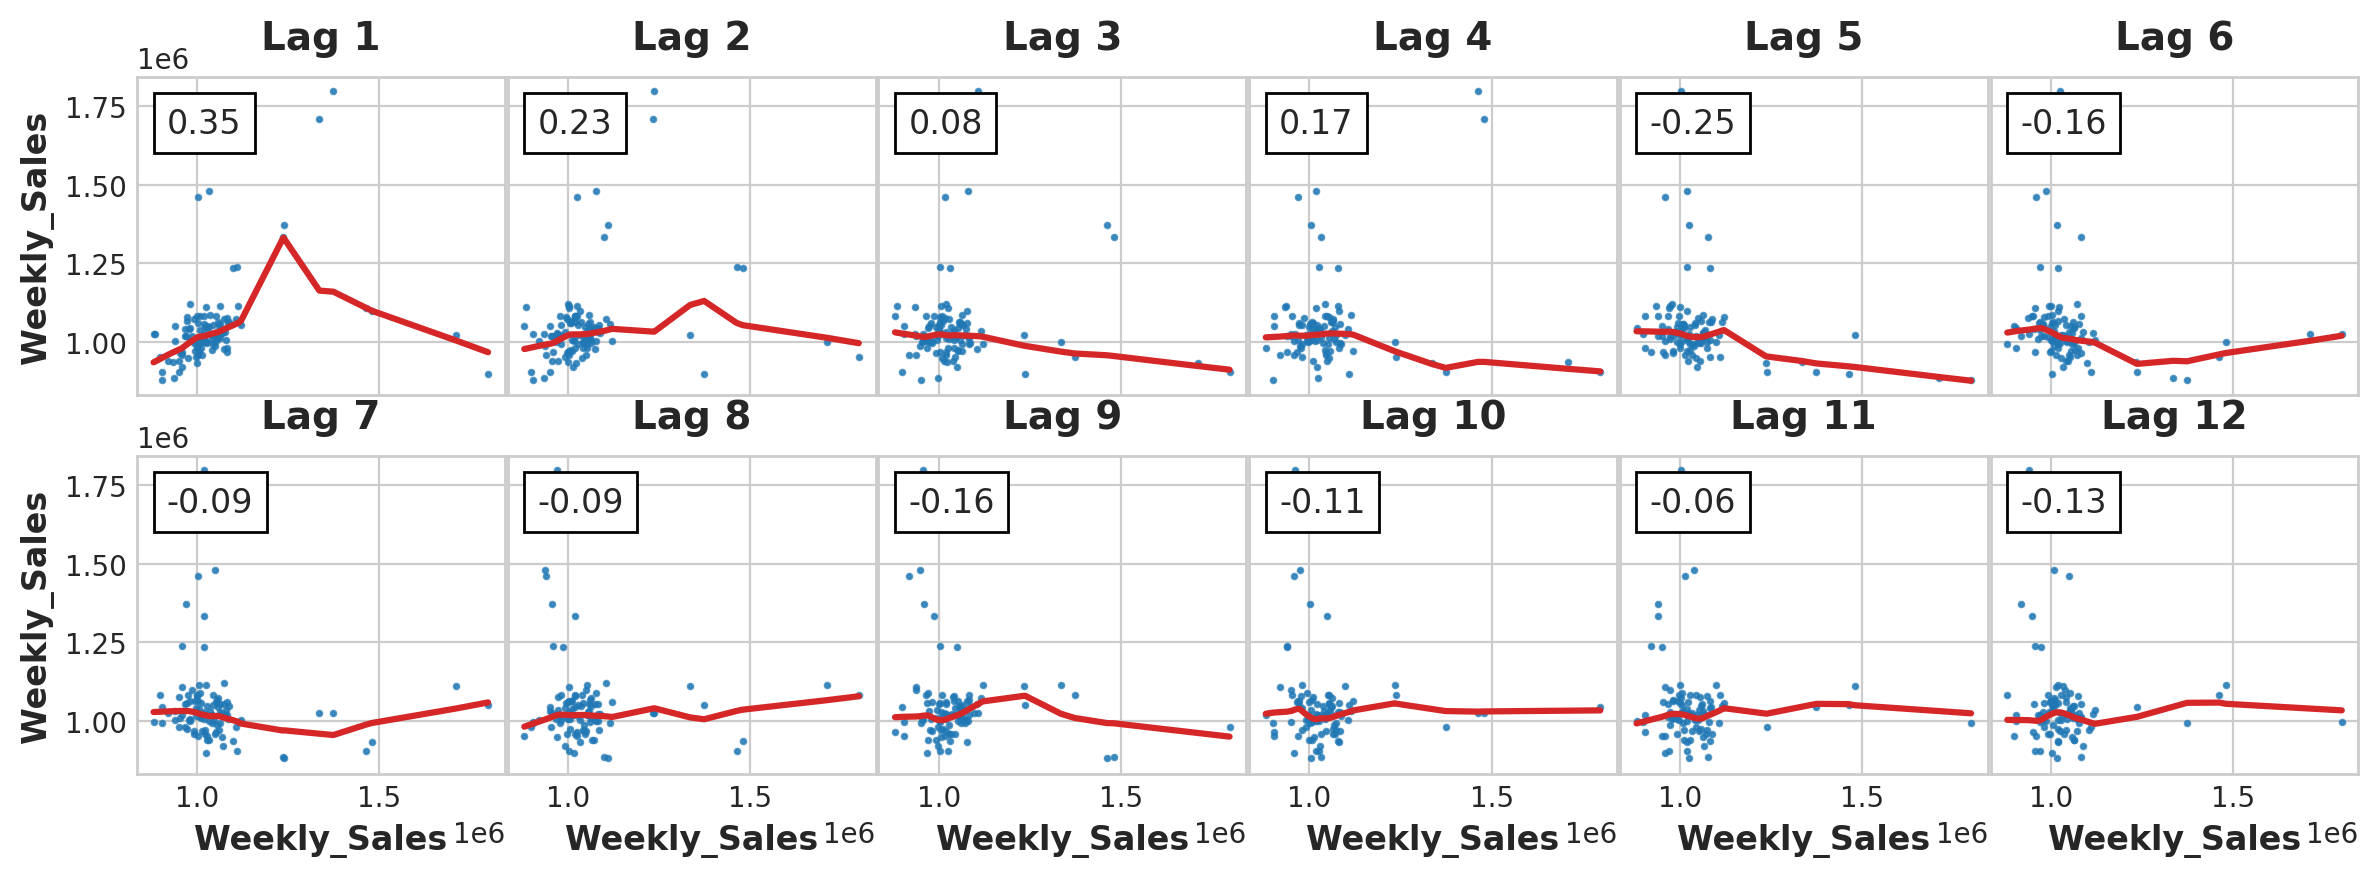

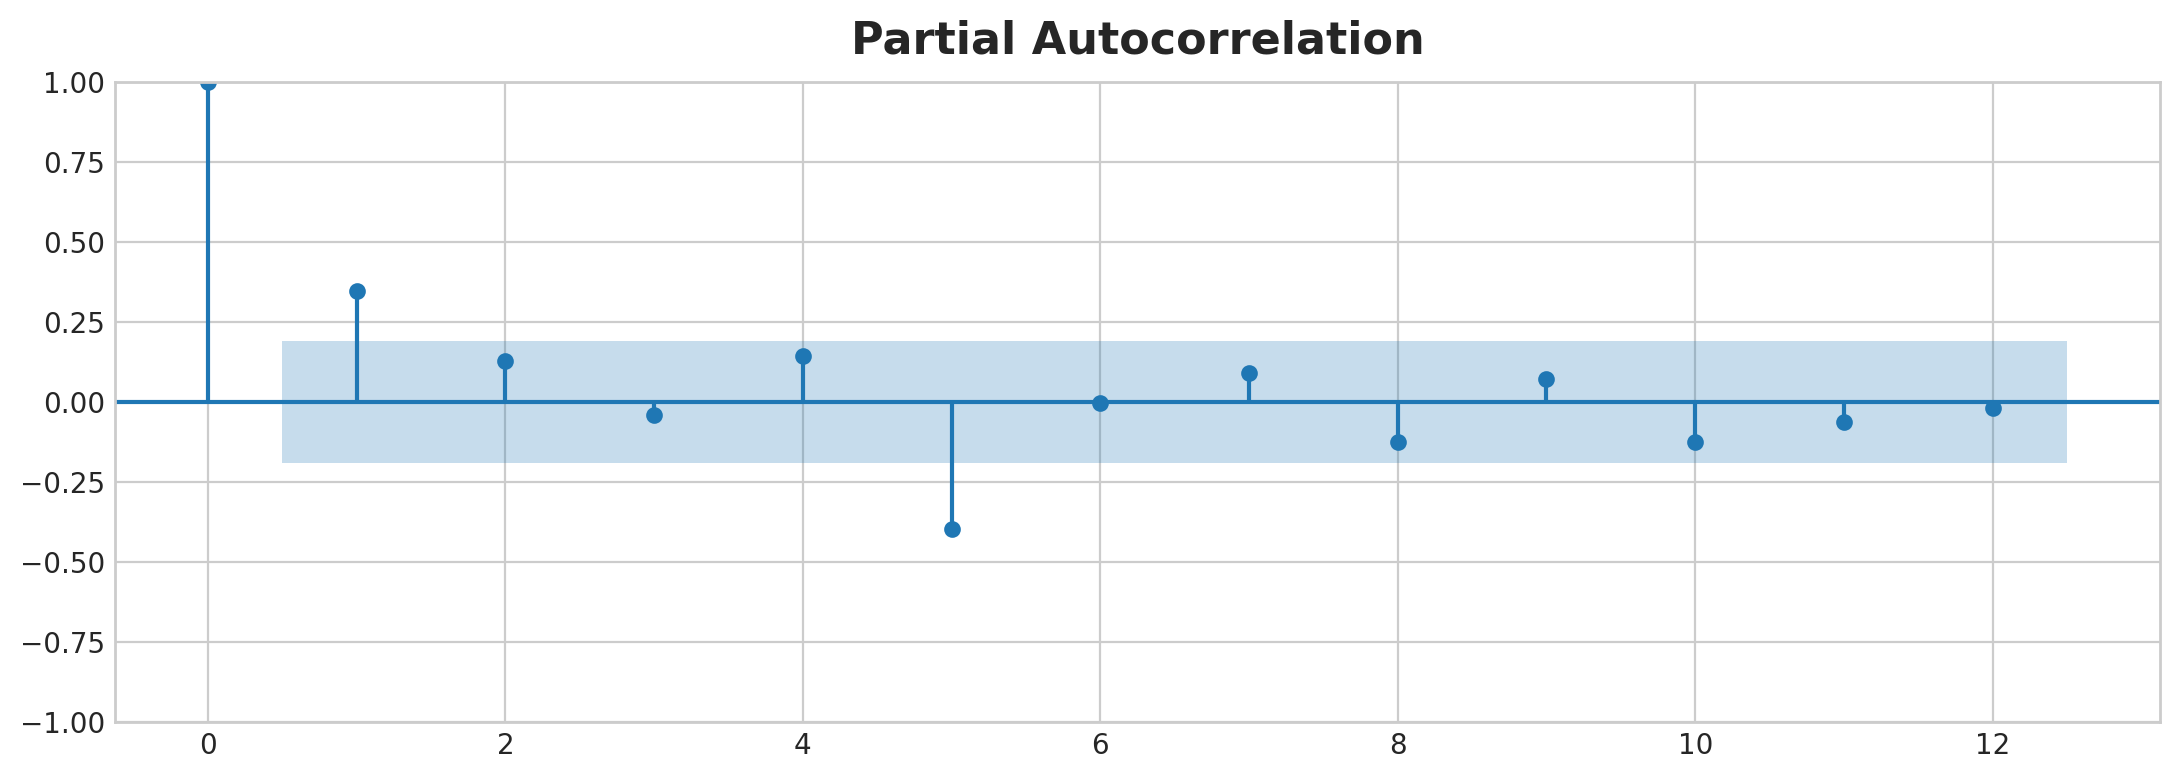

In [51]:
_ = plot_lags(Avg_Sales.Weekly_Sales, lags=12, nrows=2)
_ = plot_pacf(Avg_Sales.Weekly_Sales, lags=12)

Lag plots show replationship of weekly sales to its lags could be linear for lag of 1, if not for the outliers, likely from the holiday weeks.

In [52]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)



In [53]:

X = make_lags(Avg_Sales.Weekly_Sales, lags=1)
X = X.fillna(0.0)

In [54]:
X

,y_lag_1
Date,
2010-02-05,0.000000e+00
2010-02-12,1.105572e+06
2010-02-19,1.074148e+06
2010-02-26,1.072822e+06
2010-03-05,9.770794e+05
...,...
2012-01-20,9.338462e+05
2012-01-27,9.351333e+05
2012-02-03,8.852217e+05


In [55]:
y = Avg_Sales.Weekly_Sales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, shuffle=False)

In [56]:
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

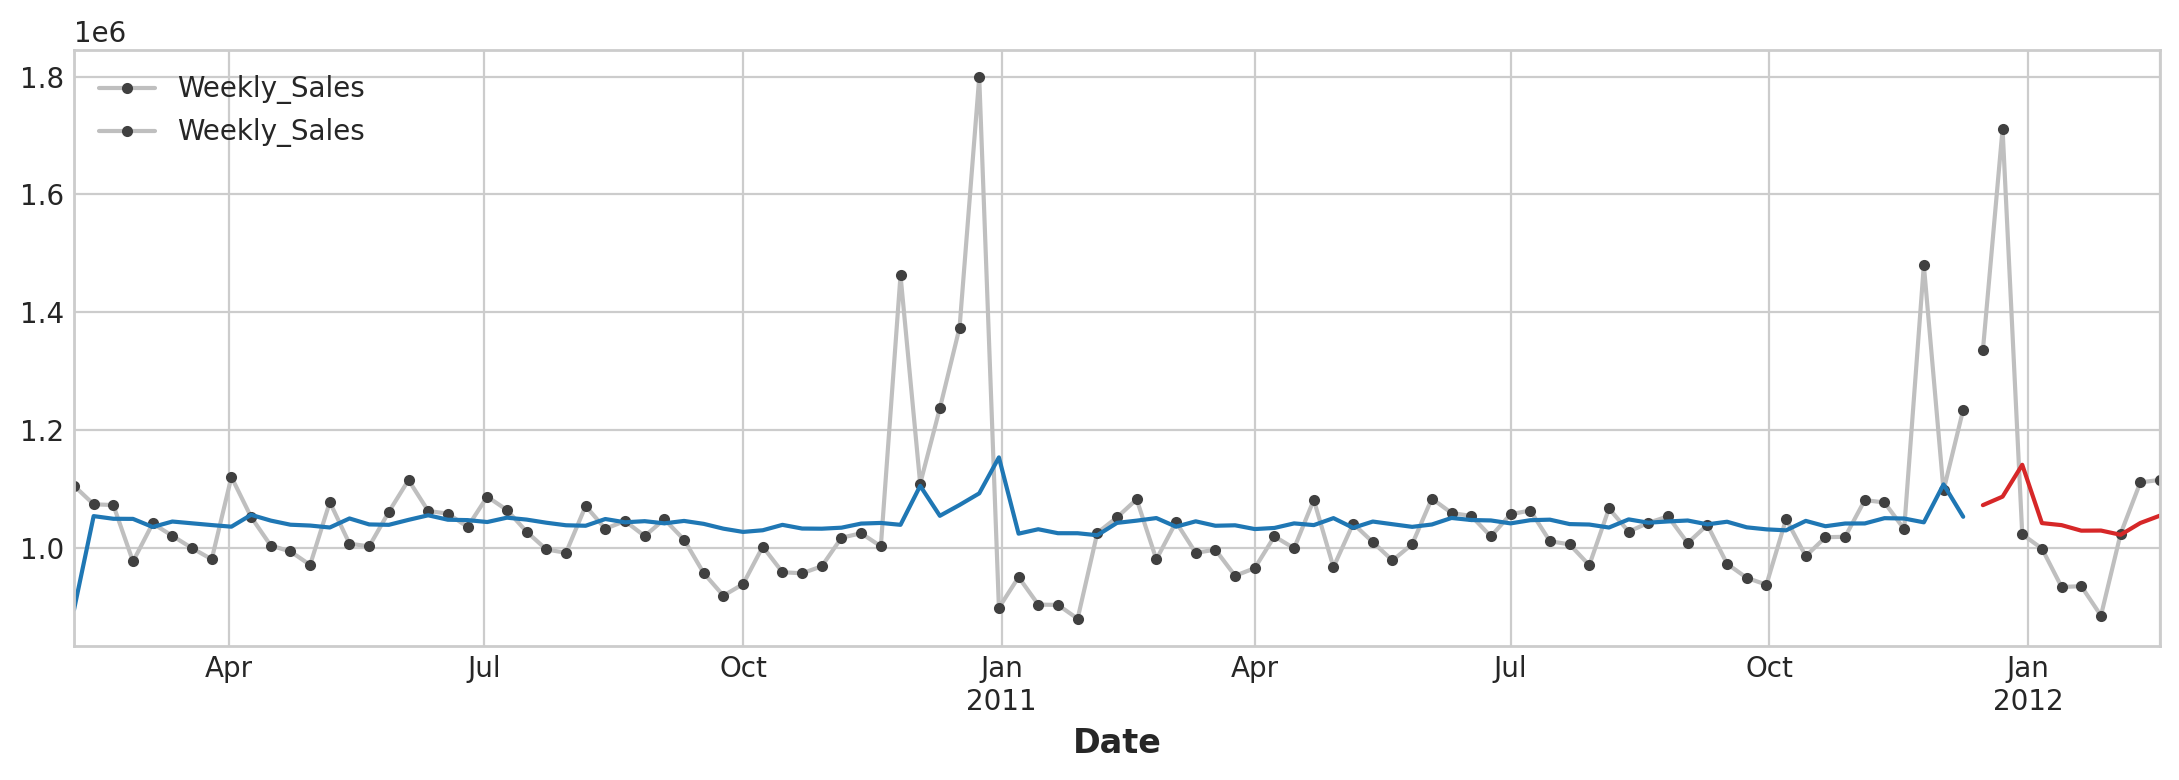

In [57]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

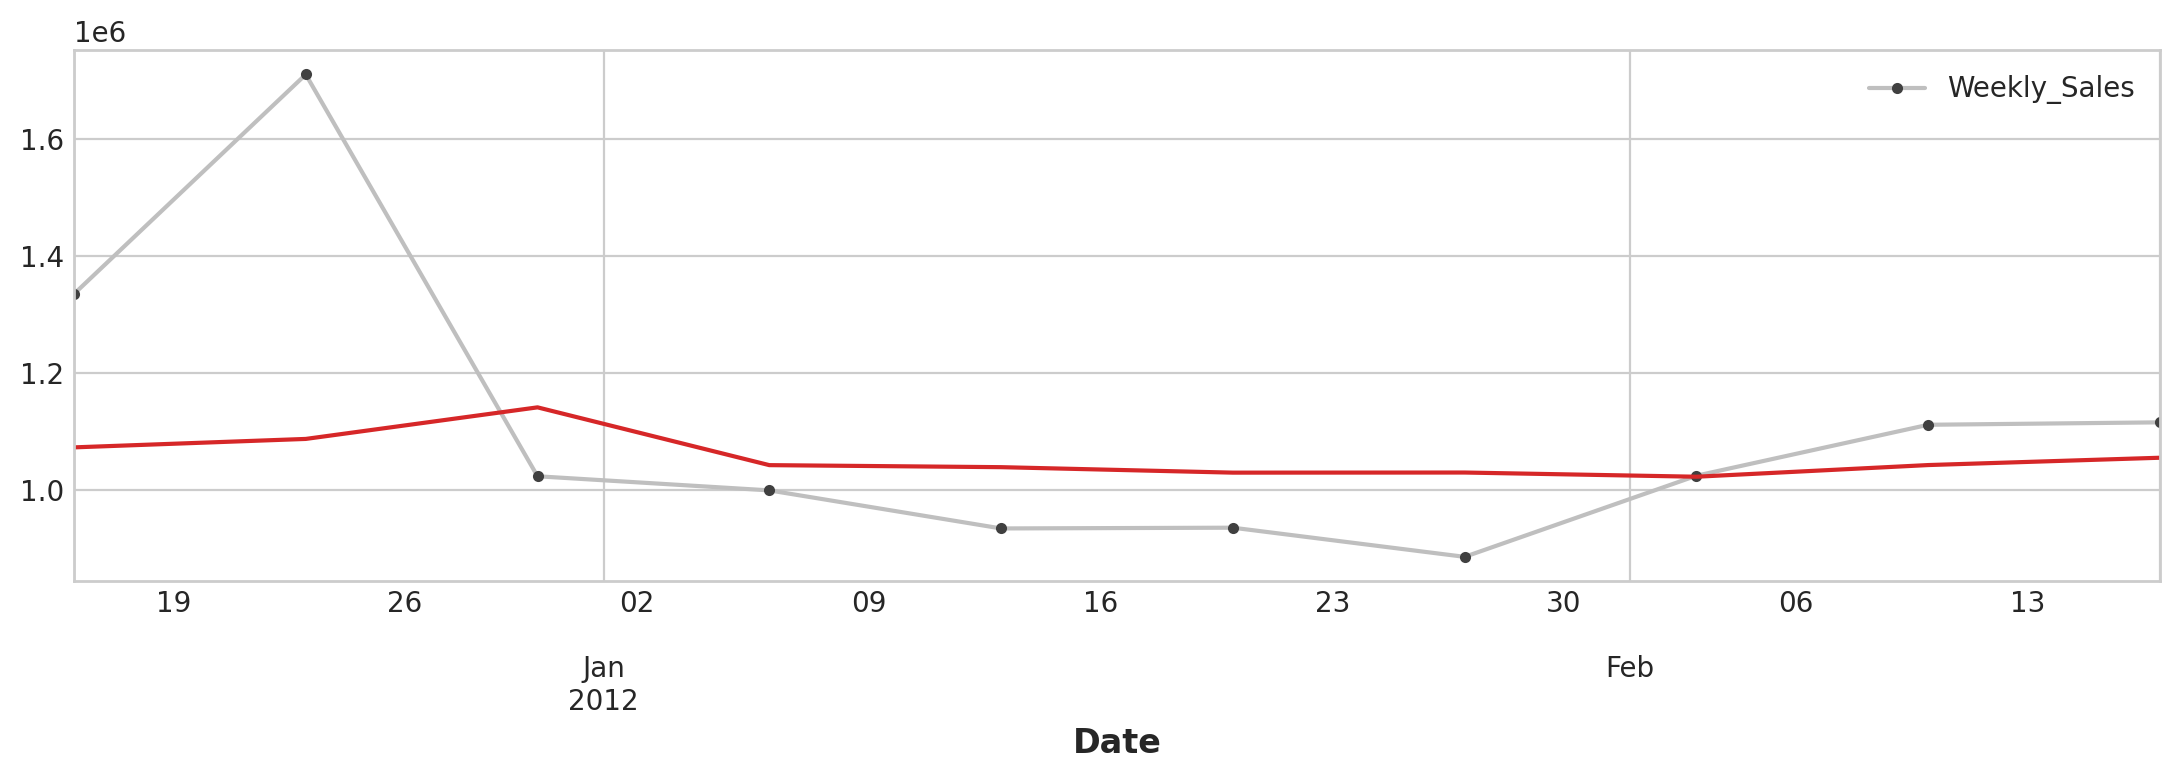

In [58]:

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

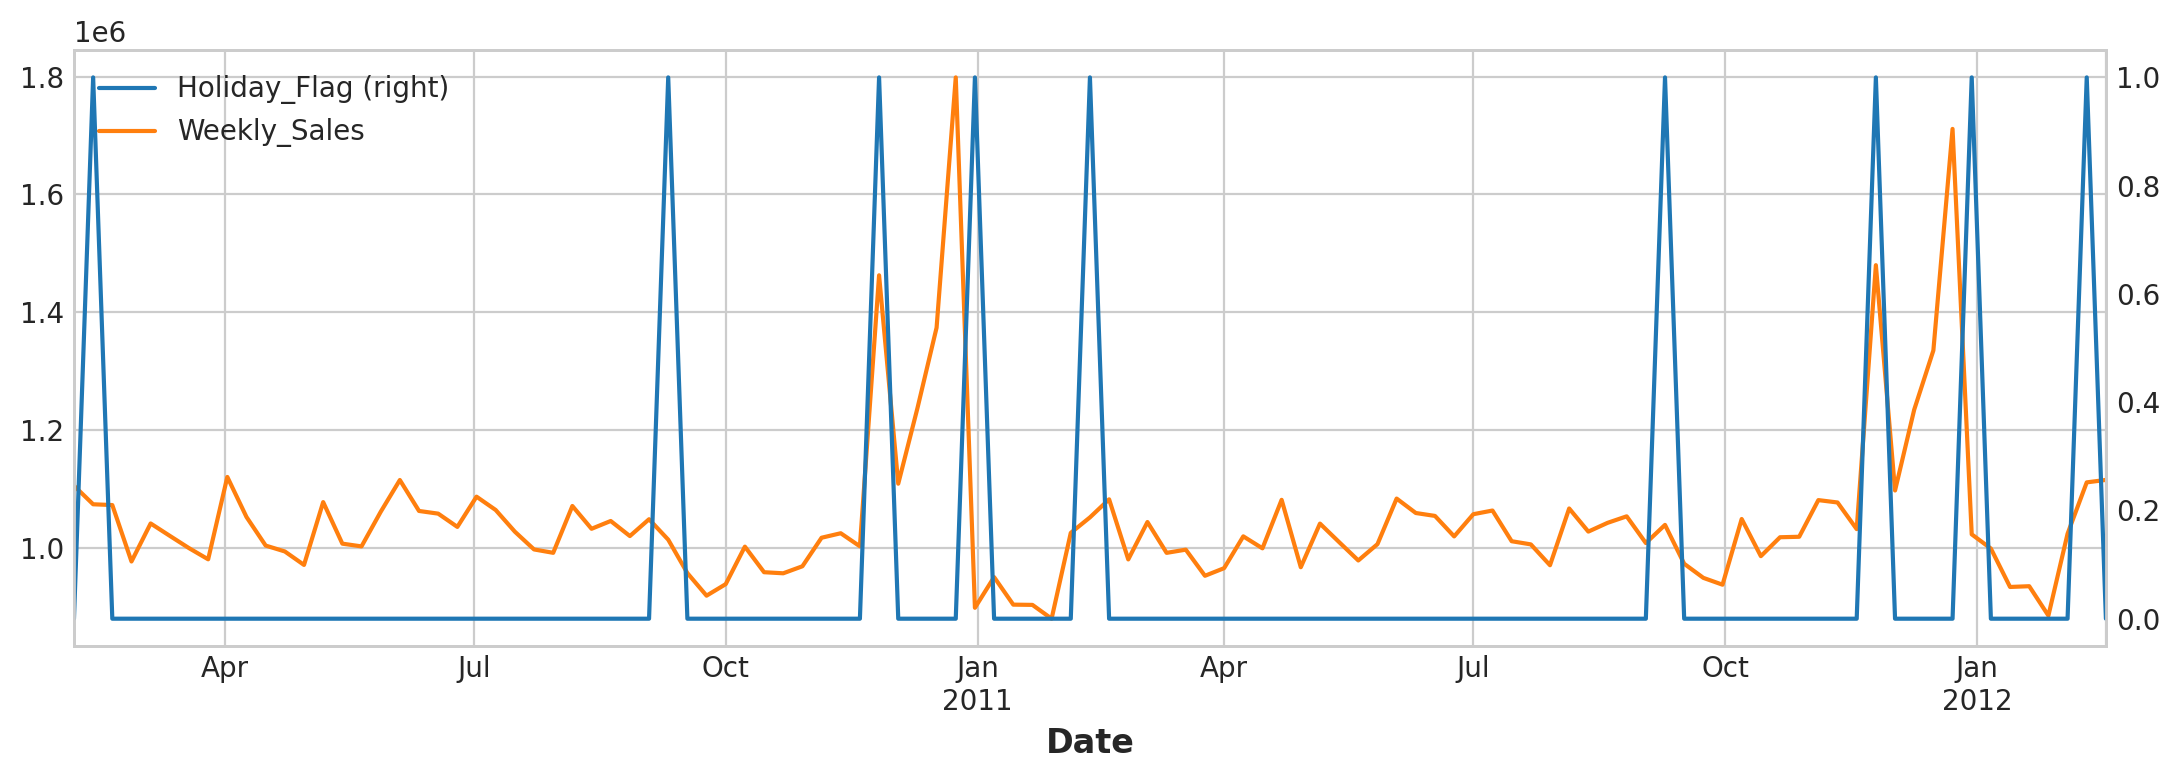

In [59]:
ax = Avg_Sales.plot(
    y=["Holiday_Flag", "Weekly_Sales"],
    secondary_y="Holiday_Flag",
)

Some of the holidays seem indicative.

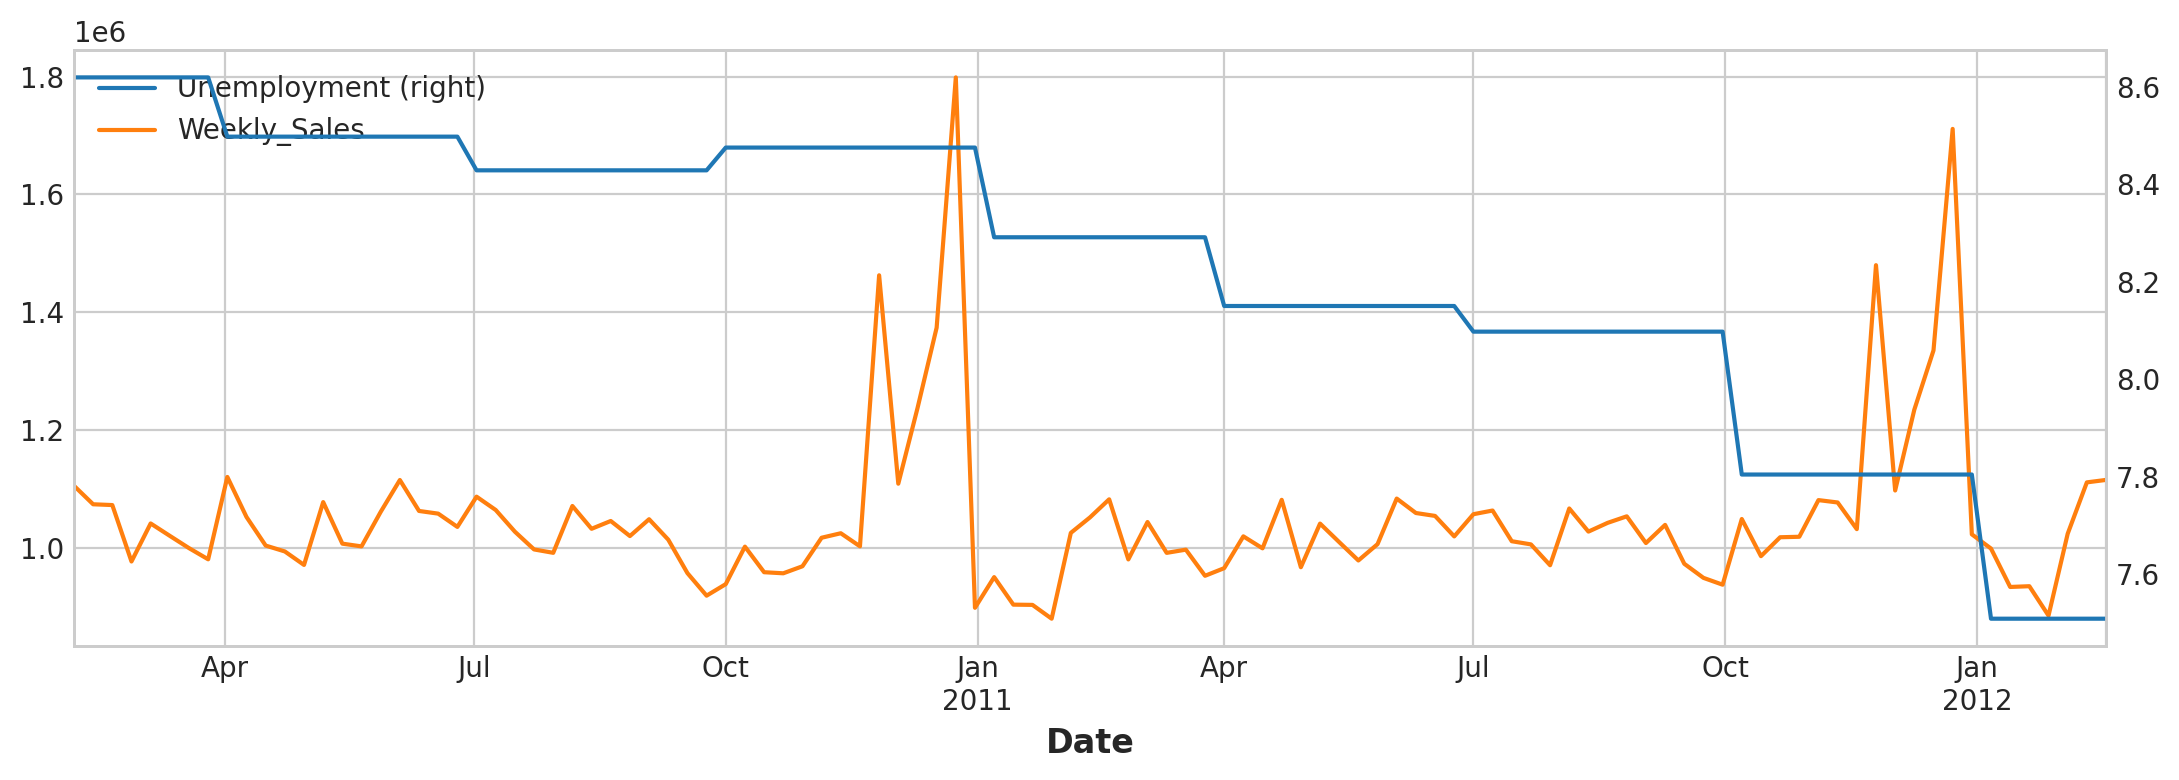

In [60]:
ax = Avg_Sales.plot(
    y=["Unemployment", "Weekly_Sales"],
    secondary_y="Unemployment",
)

Unemployment doesn't seem to be much of an indicator for weekly sales here.

We won't have to lag the holidays to be indicative of higher sales since we know when the holidays are, but it looks like the biggest sale days are Black Friday and day after Christmas.

In [61]:
Avg_Sales[Avg_Sales['Holiday_Flag']==1]

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Time,Lag_1,dayofyear,week,year
Date,,,,,,,,,,,
2010-02-12,1.074148e+06,1,34.151333,2.694022,167.825608,8.619311,1,1.105572e+06,43,6,2010
2010-09-10,1.014098e+06,1,72.449778,2.721356,168.228792,8.428578,31,1.048761e+06,253,36,2010
2010-11-26,1.462689e+06,1,47.889556,2.917956,168.541611,8.475289,42,1.002791e+06,330,47,2010
2010-12-31,8.985004e+05,1,36.782667,3.048222,168.522268,8.475289,47,1.798476e+06,365,52,2010
2011-02-11,1.051915e+06,1,32.159111,3.162400,169.500283,8.291200,53,1.025625e+06,42,6,2011
2011-09-09,1.039183e+06,1,73.447556,3.681956,172.095478,8.097489,83,1.008369e+06,252,36,2011
2011-11-25,1.479858e+06,1,49.627556,3.434311,173.409555,7.804222,94,1.031977e+06,329,47,2011
2011-12-30,1.023166e+06,1,37.926222,3.271067,173.991933,7.804222,99,1.711072e+06,364,52,2011
2012-02-10,1.111320e+06,1,39.848000,3.500800,174.550920,7.508333,105,1.024125e+06,41,6,2012


In [62]:
def sale_weeks(date):
    # Find Black Friday and day after Christmas dates for the year of the given date
    black_friday = [pd.Period(datetime.date(date.year, 11, week[calendar.FRIDAY]), 'D') \
                    for week in calendar.monthcalendar(date.year, 11) if week[calendar.FRIDAY] != 0][3]
    after_xmas = pd.Period(datetime.date(date.year, 12, 26), 'D')
    
    # Calculate 7 days prior
    black_friday_prior = black_friday - pd.Timedelta(days=7)
    after_xmas_prior = after_xmas - pd.Timedelta(days=7)
    
    # Check if the given date is less than 7 days prior to Thanksgiving
    if (date > black_friday_prior and date <= black_friday) or \
    (date > after_xmas_prior and date <= after_xmas):
        return 1
    else:
        return 0


In [63]:
Avg_Sales = Avg_Sales.reset_index()
Avg_Sales['Sale_Weeks'] = Avg_Sales['Date'].apply(sale_weeks)
Avg_Sales = Avg_Sales.set_index('Date')

Let's look at the weekly sales with the sale weeks overlayed!

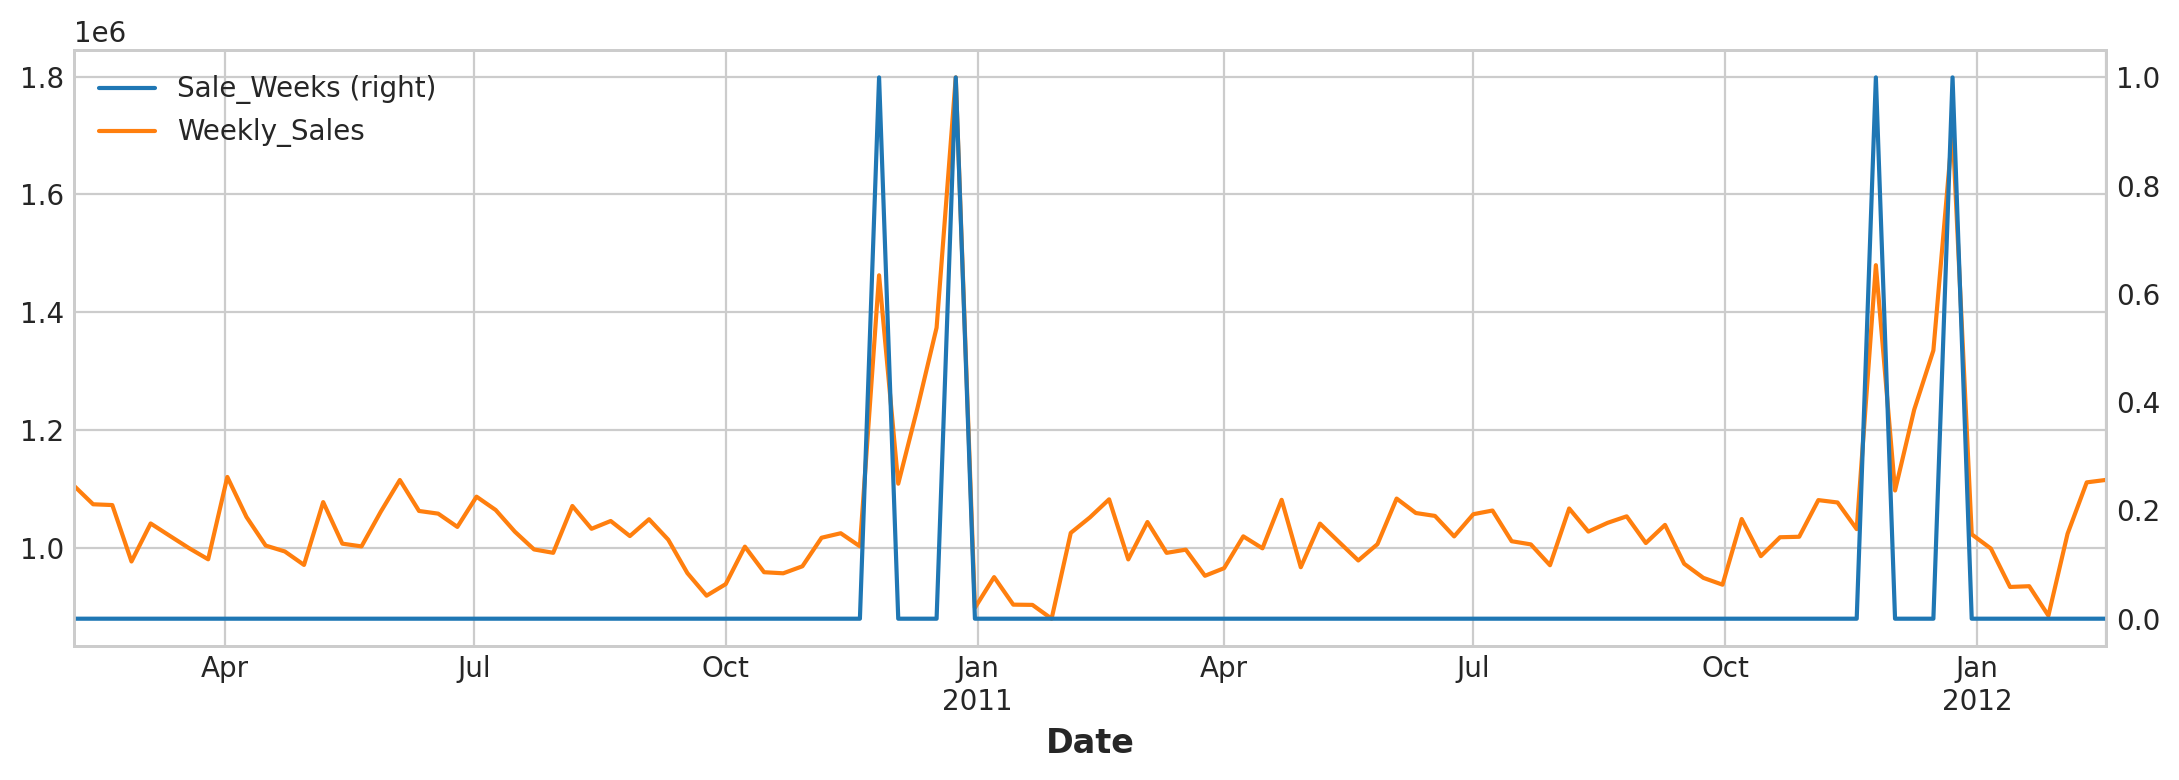

In [64]:
ax = Avg_Sales.plot(
    y=["Sale_Weeks", "Weekly_Sales"],
    secondary_y="Sale_Weeks",
)

In [65]:
X0 = Avg_Sales.Sale_Weeks
X1 = make_lags(Avg_Sales.Weekly_Sales, lags=1)
X = pd.concat([X0, X1], axis=1).fillna(0.0)

In [66]:
X

,Sale_Weeks,y_lag_1
Date,,
2010-02-05,0,0.000000e+00
2010-02-12,0,1.105572e+06
2010-02-19,0,1.074148e+06
2010-02-26,0,1.072822e+06
2010-03-05,0,9.770794e+05
...,...,...
2012-01-20,0,9.338462e+05
2012-01-27,0,9.351333e+05
2012-02-03,0,8.852217e+05


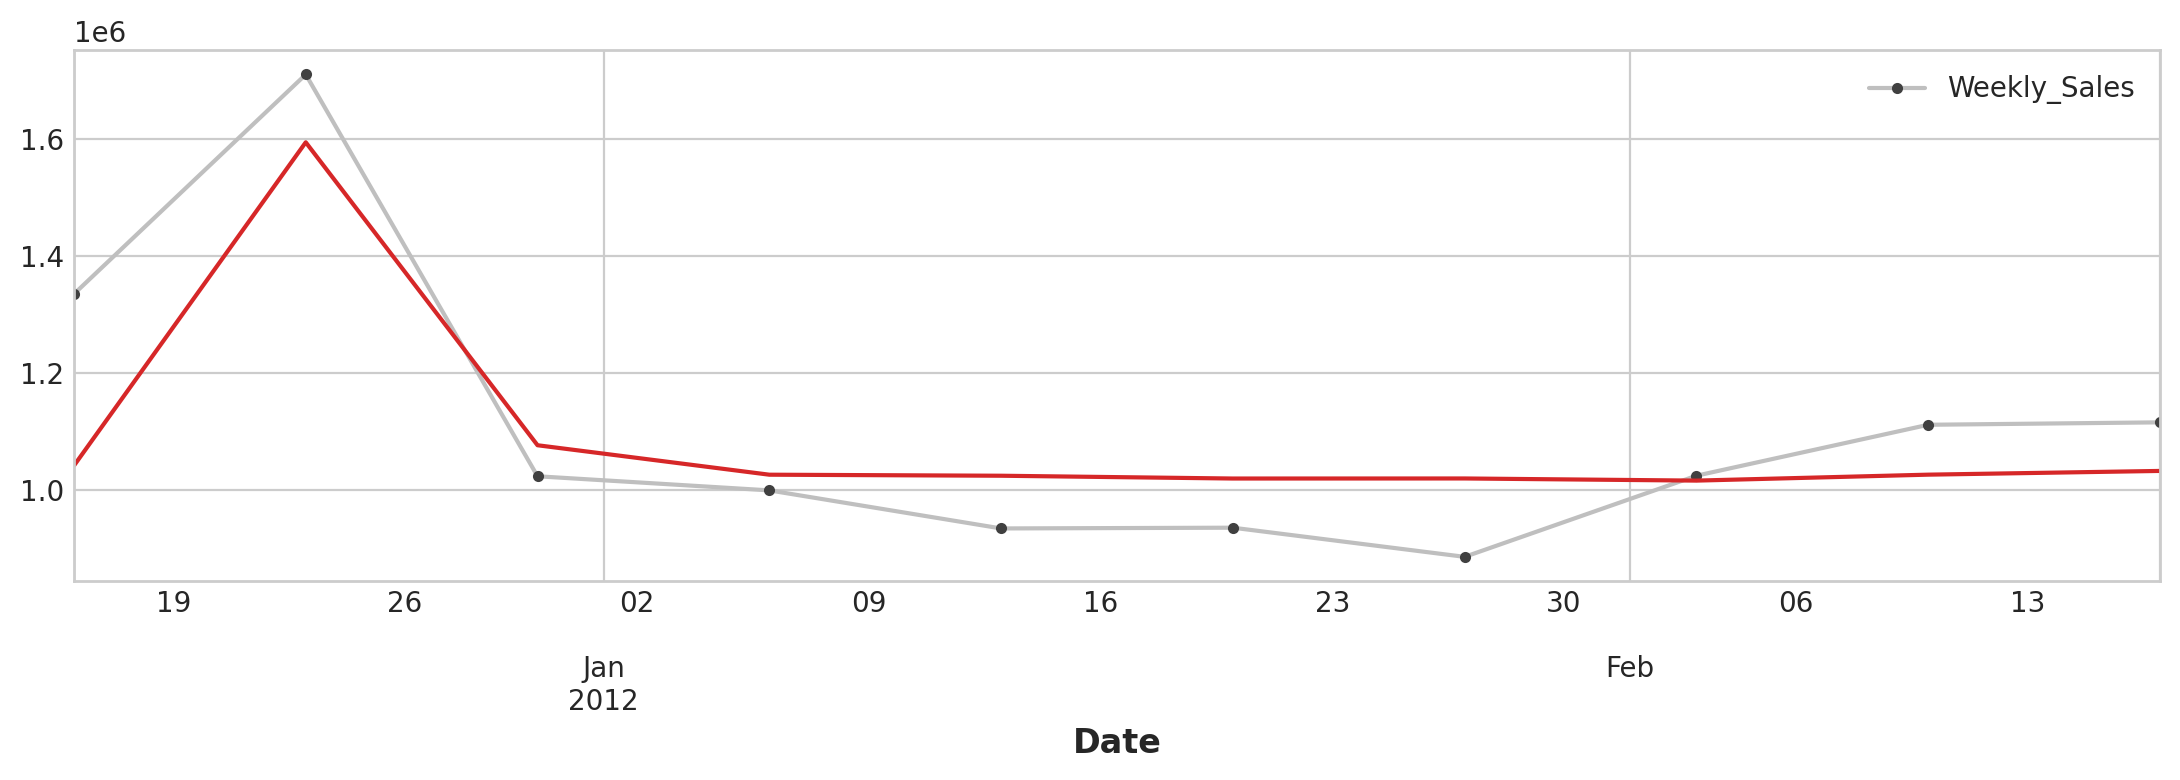

In [67]:
y = Avg_Sales.Weekly_Sales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

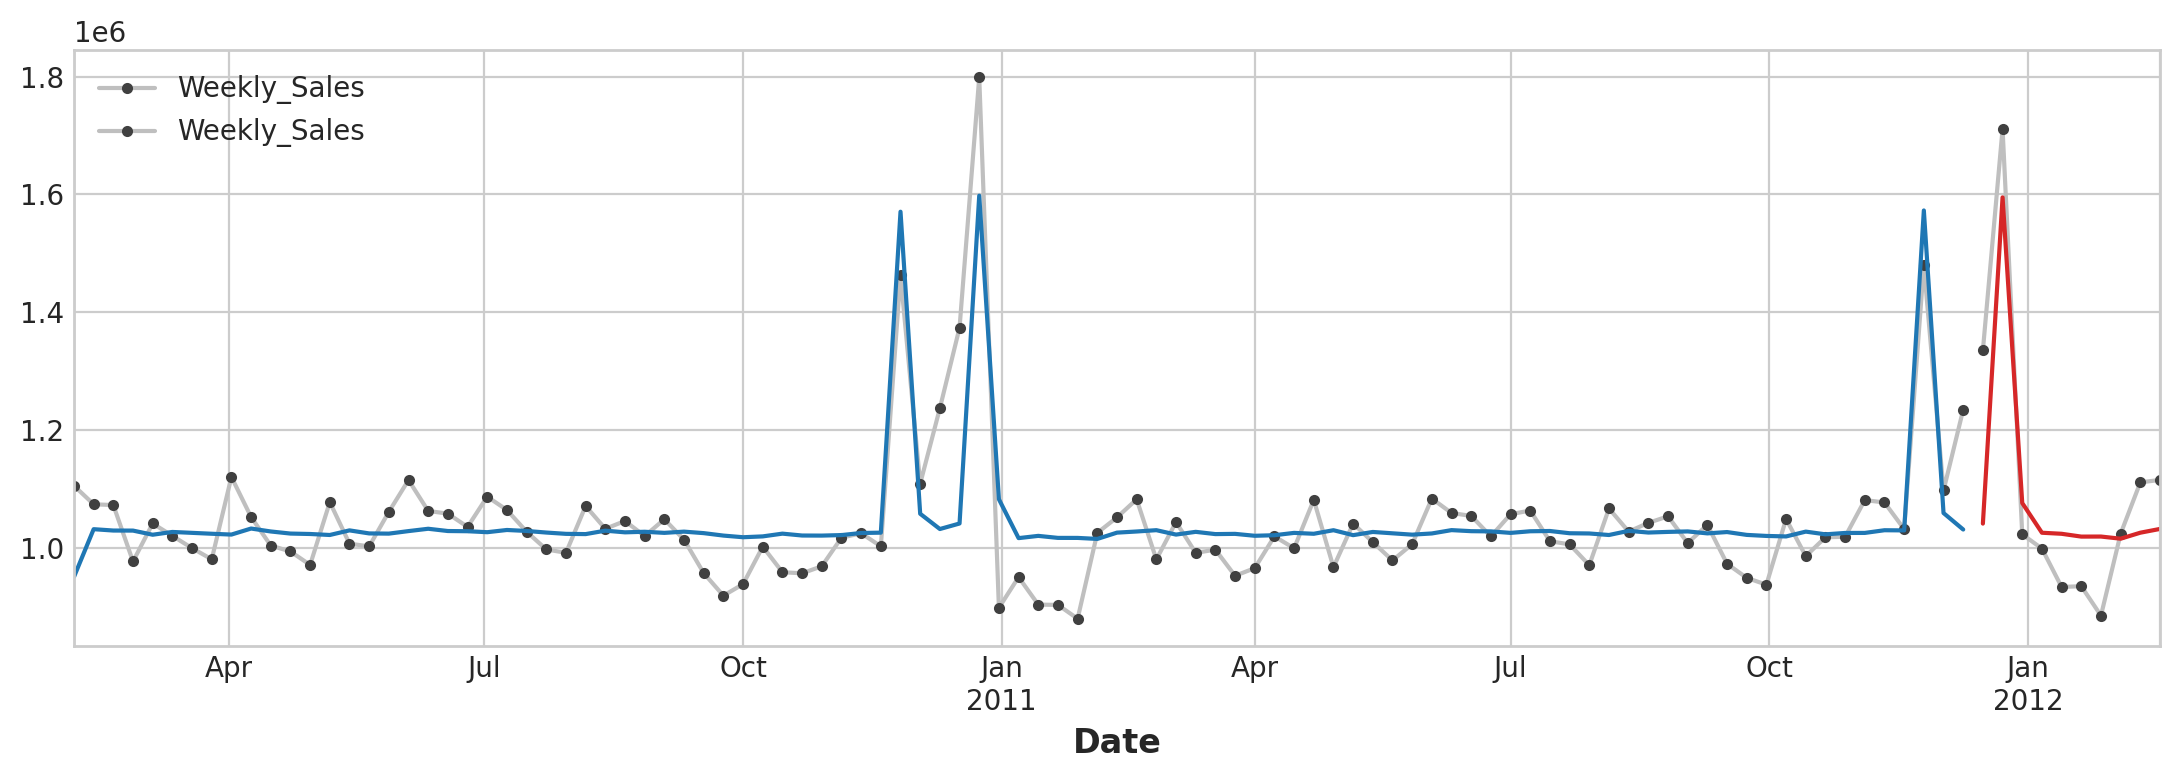

In [68]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')